In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [2]:
#Load gene dataframe and select tissue

tissue = 'blood'

top_n = 200

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select top N
gene_df = gene_df.iloc[:top_n].copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 200
len(tissue_genes) = 200


In [3]:
#Load scores for the selected set of GTEx tissues (grad)

import gc

gtex_tissues = ['blood', 'liver', 'brain', 'muscle', 'esophagus']

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores_hyp = []
all_scores = []

#Loop over tissues
for gtex_tissue in gtex_tissues :
    
    print("tissue = '" + gtex_tissue + "'")

    score_file = h5py.File('scores_v2/gtex_' + gtex_tissue + '_log2fc_undo_clip_scores_mean.h5', 'r')

    #Get scores and onehots
    scores = score_file['grads'][()][..., 0]
    seqs = score_file['seqs'][()]

    #Get auxiliary information
    strands = score_file['strand'][()]
    strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

    chrs = score_file['chr'][()]
    chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

    starts = np.array(score_file['start'][()])
    ends = np.array(score_file['end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    scores = scores[keep_index, ...]
    seqs = seqs[keep_index, ...]
    strands = strands[keep_index]
    chrs = chrs[keep_index]
    starts = starts[keep_index]
    ends = ends[keep_index]
    genes = genes[keep_index]

    #Append hypothetical scores
    all_scores_hyp.append(scores[None, ...])

    #Append input-gated scores
    all_scores.append((scores * seqs)[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
scores_hyp = np.concatenate(all_scores_hyp, axis=0)
scores = np.concatenate(all_scores, axis=0)

print("scores_hyp.shape = " + str(scores_hyp.shape))
print("scores.shape = " + str(scores.shape))

score_file = None

#Collect garbage
gc.collect()


tissue = 'blood'
tissue = 'liver'
tissue = 'brain'
tissue = 'muscle'
tissue = 'esophagus'
scores_hyp.shape = (5, 200, 524288, 4)
scores.shape = (5, 200, 524288, 4)


0

-- Example = 0 --
 - ENSG00000169877(+)
 - chr16:31266321-31790609
 -- min_val = -0.8506
 -- max_val = 0.956
 - (Gradient score profiles per tissue) - 


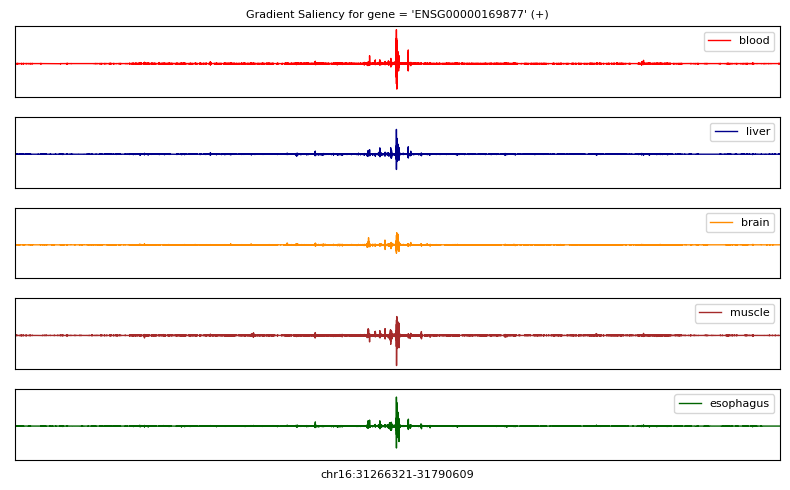

 - (Gradient score comparison against 'blood') - 
liver (r = 0.501)
brain (r = 0.374)
muscle (r = 0.221)
esophagus (r = 0.527)


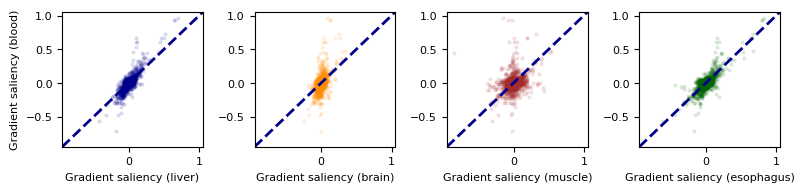

 - (Differential gradient score of blood against 'mean') -


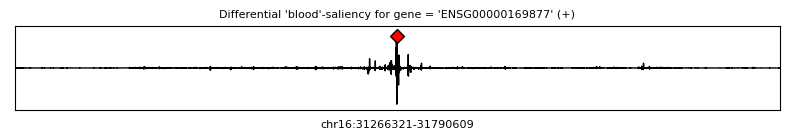

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261748
 - max_pos (abs) = 31528069
 - chr16:31527973-31528165
blood


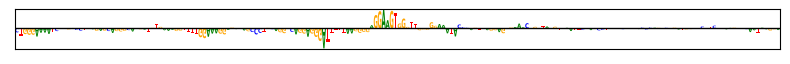

liver


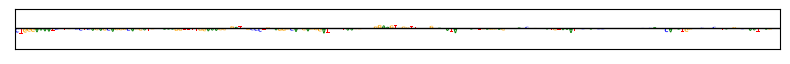

brain


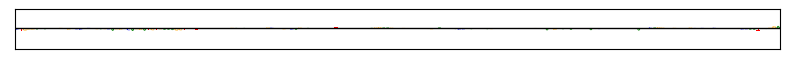

muscle


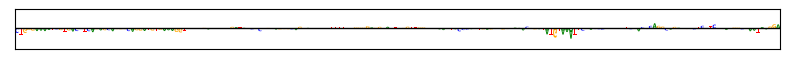

esophagus


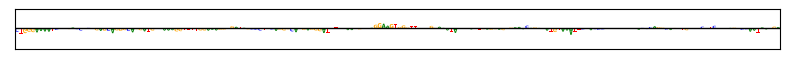

--------------------

-- Example = 1 --
 - ENSG00000206177(+)
 - chr16:-512-523776
 -- min_val = -0.626
 -- max_val = 0.7183
 - (Gradient score profiles per tissue) - 


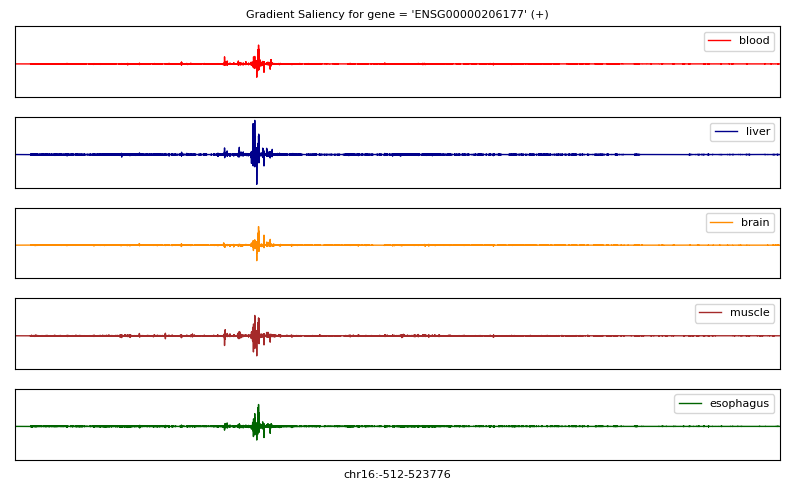

 - (Gradient score comparison against 'blood') - 
liver (r = 0.297)
brain (r = 0.263)
muscle (r = 0.426)
esophagus (r = 0.634)


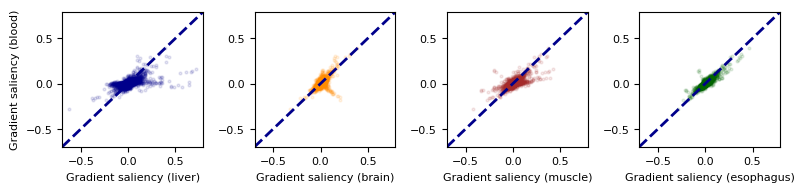

 - (Differential gradient score of blood against 'mean') -


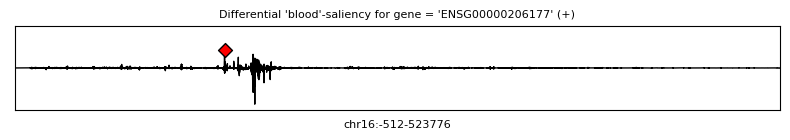

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 143679
 - max_pos (abs) = 143167
 - chr16:143071-143263
blood


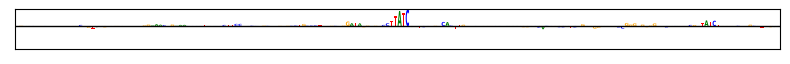

liver


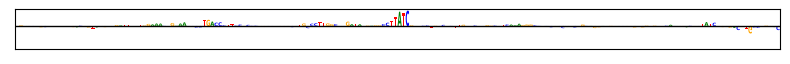

brain


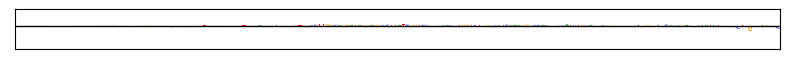

muscle


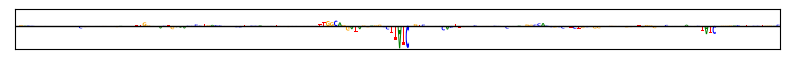

esophagus


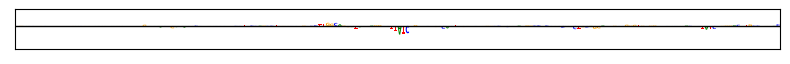

--------------------

-- Example = 2 --
 - ENSG00000118113(-)
 - chr11:102453605-102977893
 -- min_val = -0.636
 -- max_val = 2.229
 - (Gradient score profiles per tissue) - 


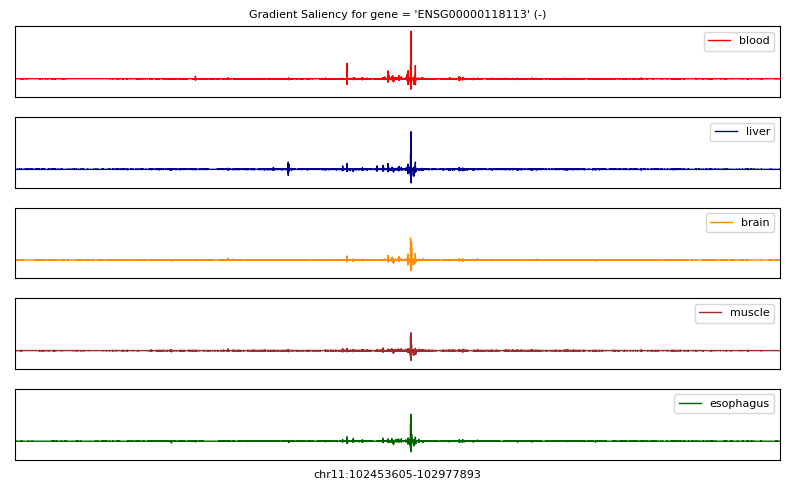

 - (Gradient score comparison against 'blood') - 
liver (r = 0.534)
brain (r = 0.434)
muscle (r = 0.369)
esophagus (r = 0.516)


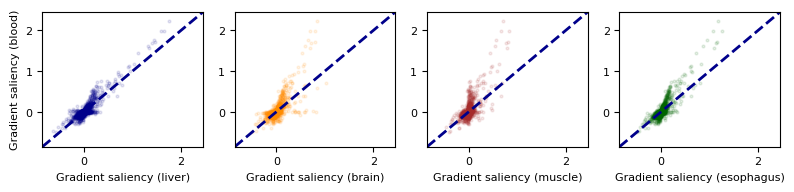

 - (Differential gradient score of blood against 'mean') -


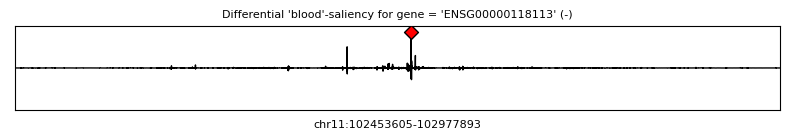

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271447
 - max_pos (abs) = 102725052
 - chr11:102724956-102725148
blood


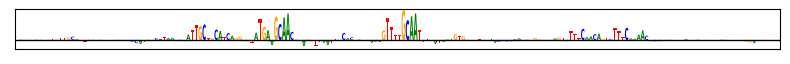

liver


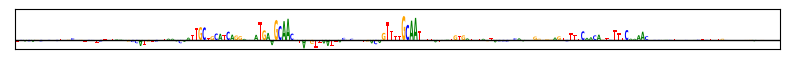

brain


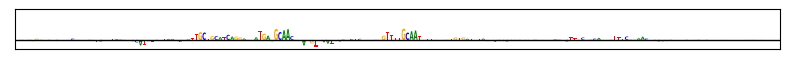

muscle


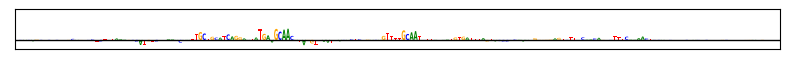

esophagus


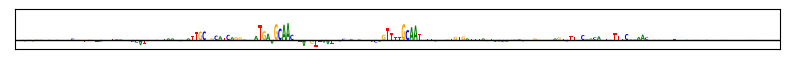

--------------------

-- Example = 3 --
 - ENSG00000110203(+)
 - chr11:71876423-72400711
 -- min_val = -2.77
 -- max_val = 5.344
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


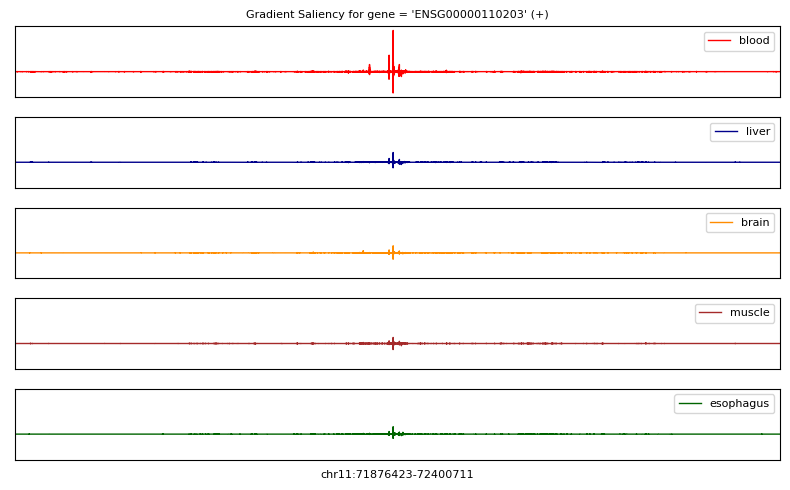

 - (Gradient score comparison against 'blood') - 
liver (r = 0.464)
brain (r = 0.385)
muscle (r = 0.313)
esophagus (r = 0.47)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


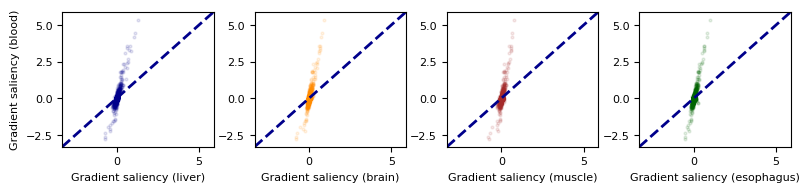

 - (Differential gradient score of blood against 'mean') -


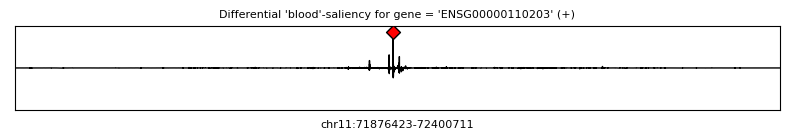

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259220
 - max_pos (abs) = 72135643
 - chr11:72135547-72135739
blood


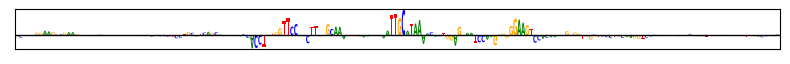

liver


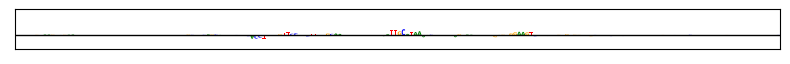

brain


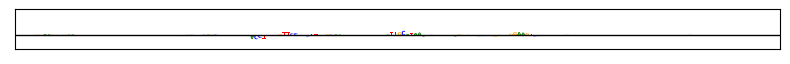

muscle


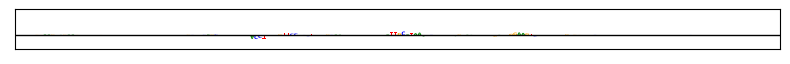

esophagus


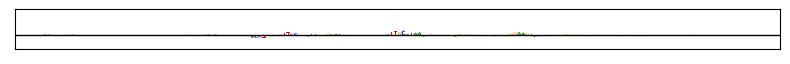

--------------------

-- Example = 4 --
 - ENSG00000126262(+)
 - chr19:35188458-35712746
 -- min_val = -0.294
 -- max_val = 1.011
 - (Gradient score profiles per tissue) - 


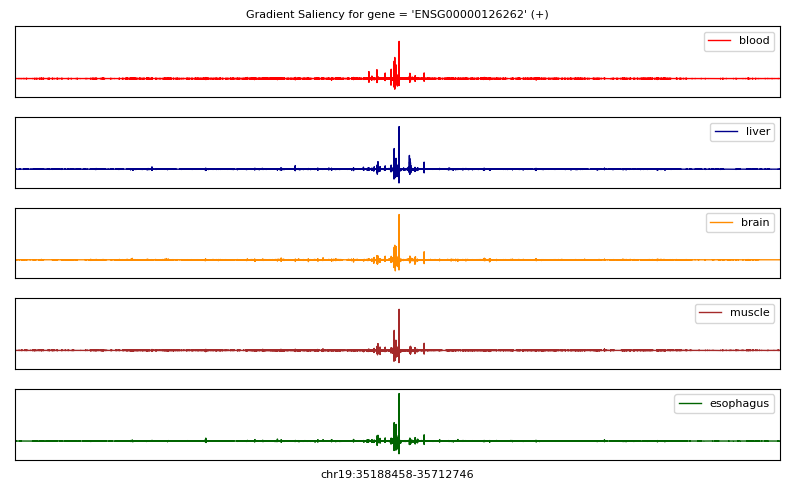

 - (Gradient score comparison against 'blood') - 
liver (r = 0.488)
brain (r = 0.338)
muscle (r = 0.459)
esophagus (r = 0.55)


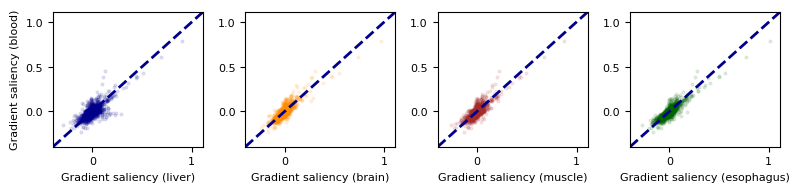

 - (Differential gradient score of blood against 'mean') -


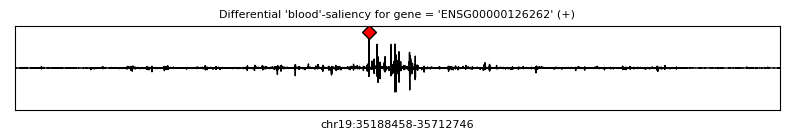

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 242602
 - max_pos (abs) = 35431060
 - chr19:35430964-35431156
blood


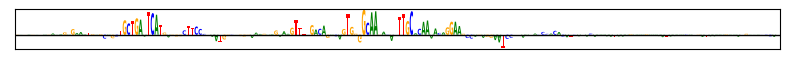

liver


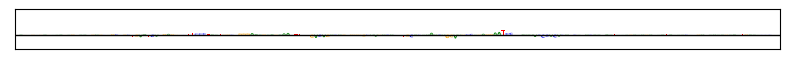

brain


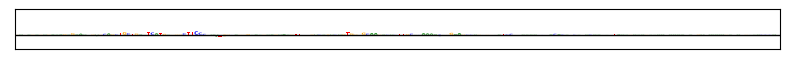

muscle


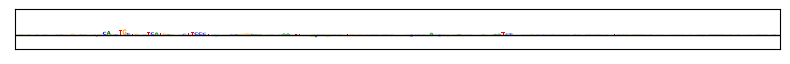

esophagus


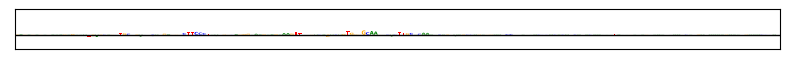

--------------------

-- Example = 5 --
 - ENSG00000004939(-)
 - chr17:43991866-44516154
 -- min_val = -0.8486
 -- max_val = 1.306
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


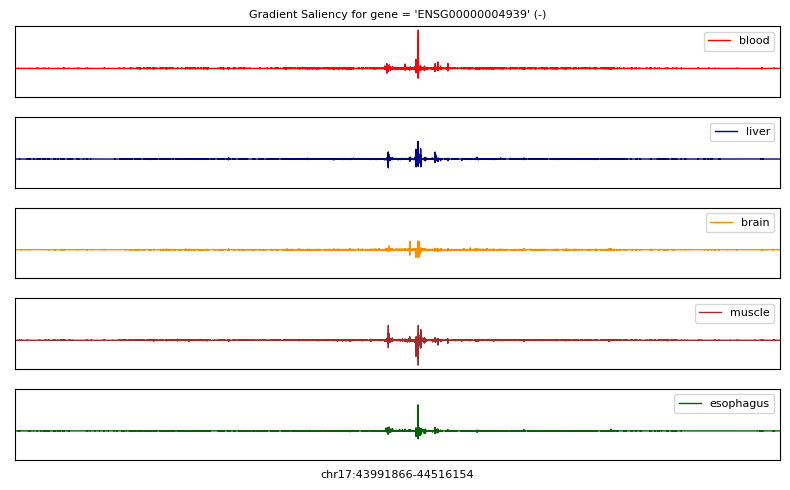

 - (Gradient score comparison against 'blood') - 
liver (r = 0.136)
brain (r = 0.154)
muscle (r = 0.088)
esophagus (r = 0.435)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


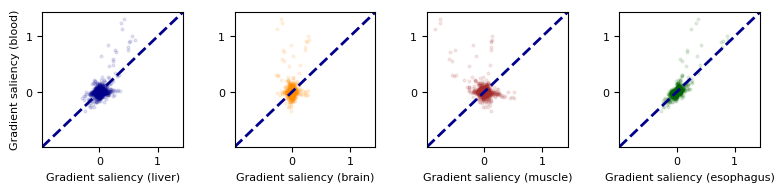

 - (Differential gradient score of blood against 'mean') -


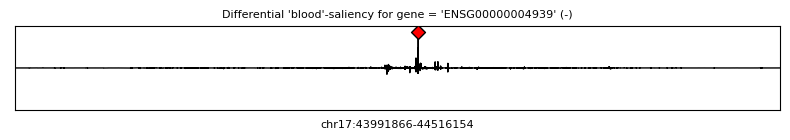

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 276410
 - max_pos (abs) = 44268276
 - chr17:44268180-44268372
blood


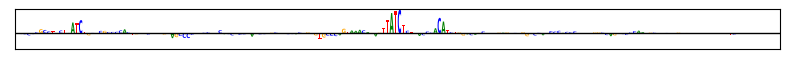

liver


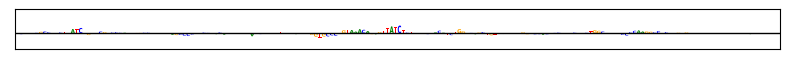

brain


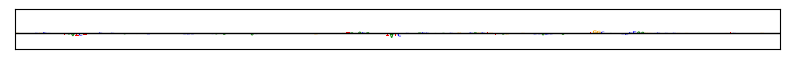

muscle


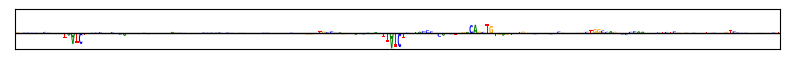

esophagus


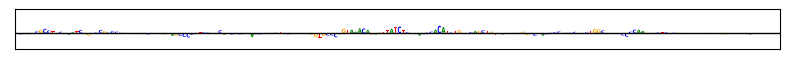

--------------------

-- Example = 6 --
 - ENSG00000171049(+)
 - chr19:51507222-52031510
 -- min_val = -1.027
 -- max_val = 2.541
 - (Gradient score profiles per tissue) - 


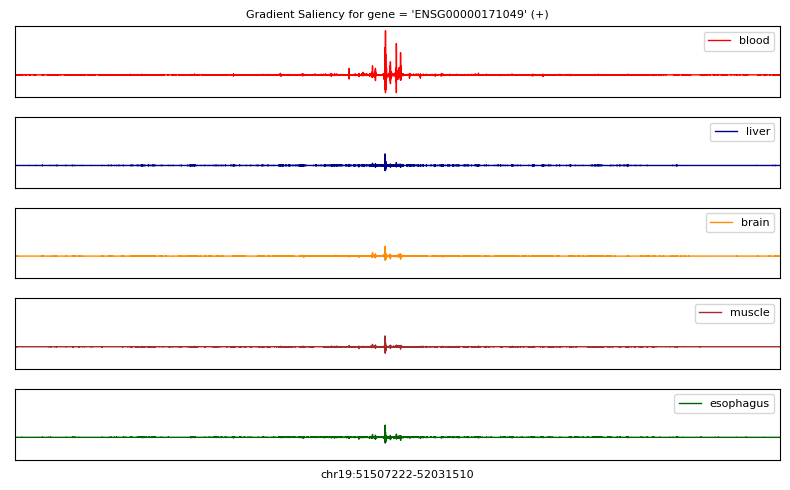

 - (Gradient score comparison against 'blood') - 
liver (r = 0.475)
brain (r = 0.305)
muscle (r = 0.321)
esophagus (r = 0.508)


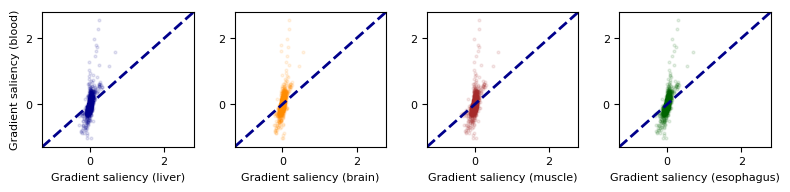

 - (Differential gradient score of blood against 'mean') -


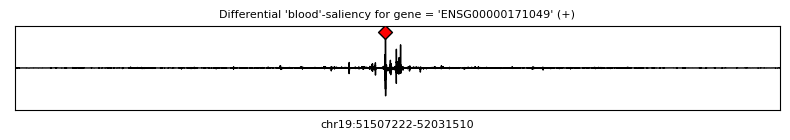

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253961
 - max_pos (abs) = 51761183
 - chr19:51761087-51761279
blood


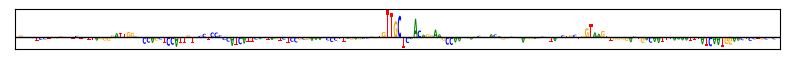

liver


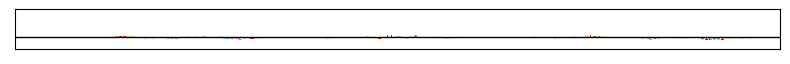

brain


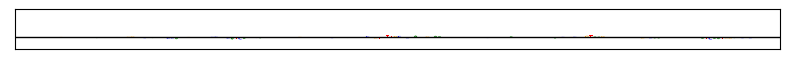

muscle


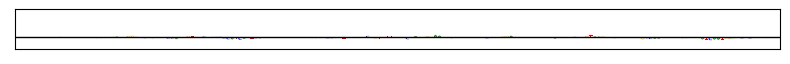

esophagus


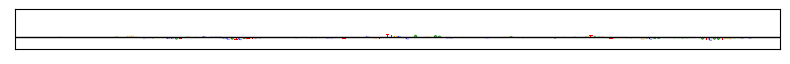

--------------------

-- Example = 7 --
 - ENSG00000180871(+)
 - chr2:217872624-218396912
 -- min_val = -1.531
 -- max_val = 0.9927
 - (Gradient score profiles per tissue) - 


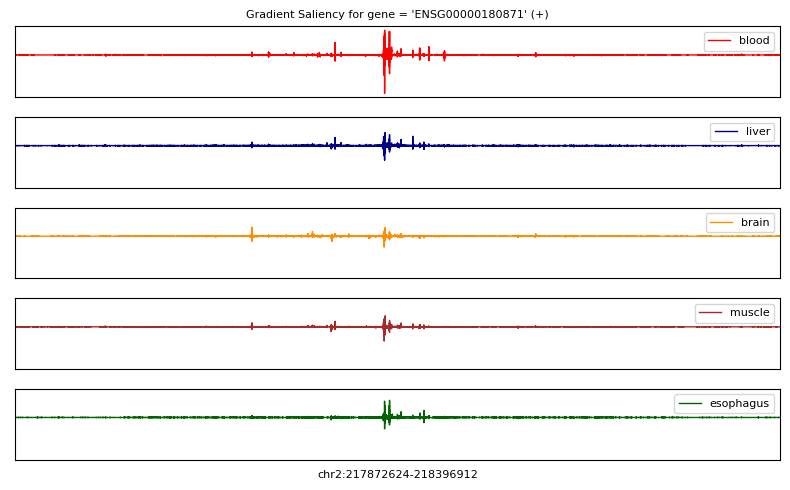

 - (Gradient score comparison against 'blood') - 
liver (r = 0.559)
brain (r = 0.326)
muscle (r = 0.474)
esophagus (r = 0.388)


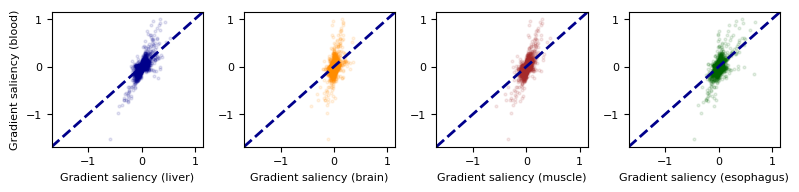

 - (Differential gradient score of blood against 'mean') -


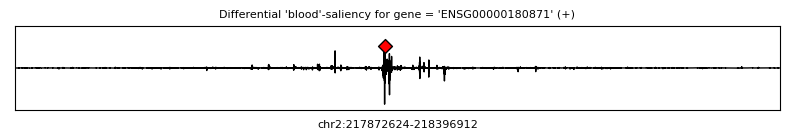

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253310
 - max_pos (abs) = 218125934
 - chr2:218125838-218126030
blood


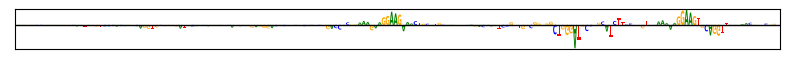

liver


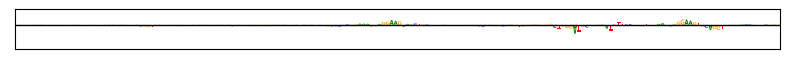

brain


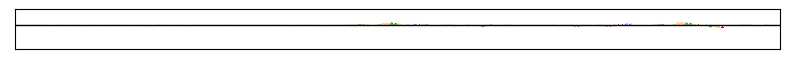

muscle


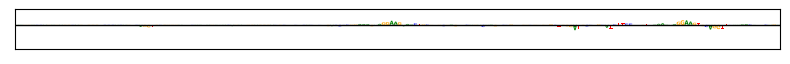

esophagus


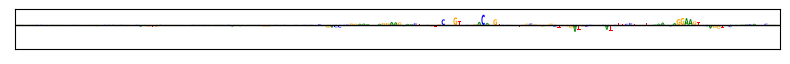

--------------------

-- Example = 8 --
 - ENSG00000204936(+)
 - chr19:43097819-43622107
 -- min_val = -0.3672
 -- max_val = 0.9526
 - (Gradient score profiles per tissue) - 


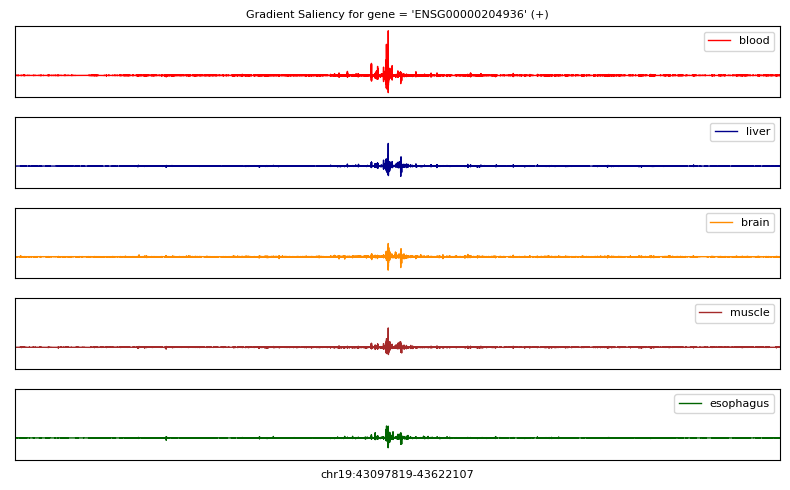

 - (Gradient score comparison against 'blood') - 
liver (r = 0.444)
brain (r = 0.24)
muscle (r = 0.422)
esophagus (r = 0.364)


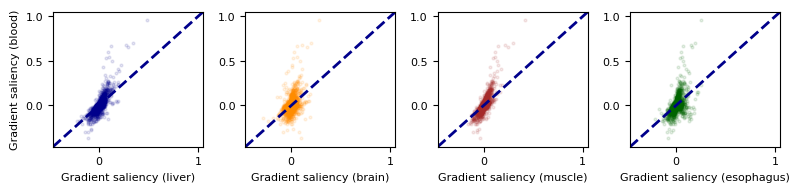

 - (Differential gradient score of blood against 'mean') -


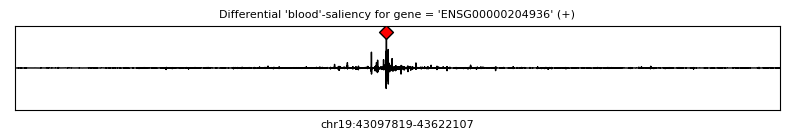

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254606
 - max_pos (abs) = 43352425
 - chr19:43352329-43352521
blood


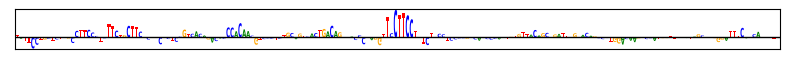

liver


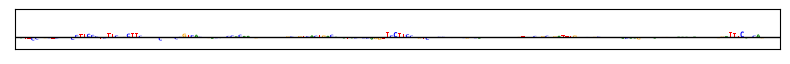

brain


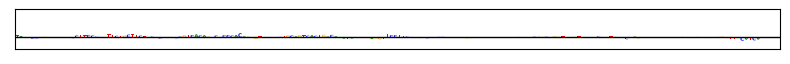

muscle


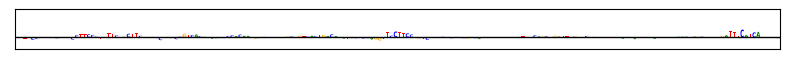

esophagus


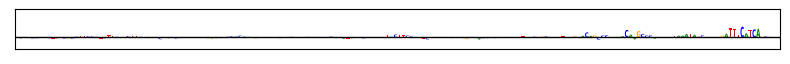

--------------------

-- Example = 9 --
 - ENSG00000112195(-)
 - chr6:40930526-41454814
 -- min_val = -1.22
 -- max_val = 0.866
 - (Gradient score profiles per tissue) - 


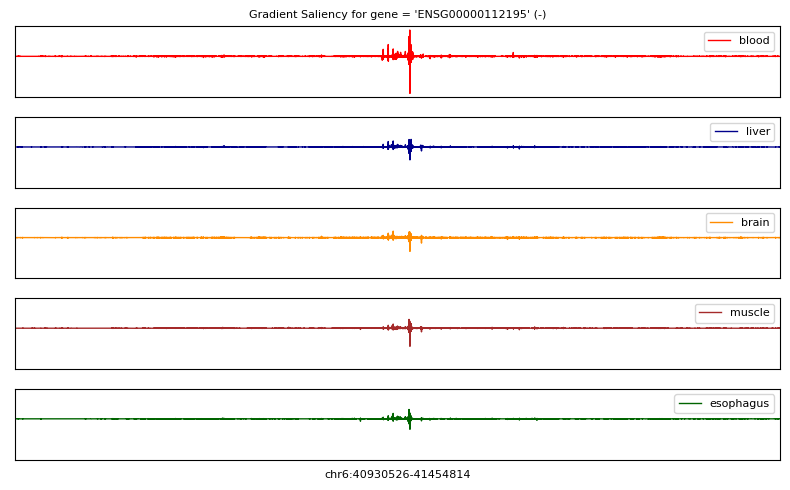

 - (Gradient score comparison against 'blood') - 
liver (r = 0.441)
brain (r = 0.287)
muscle (r = 0.349)
esophagus (r = 0.381)


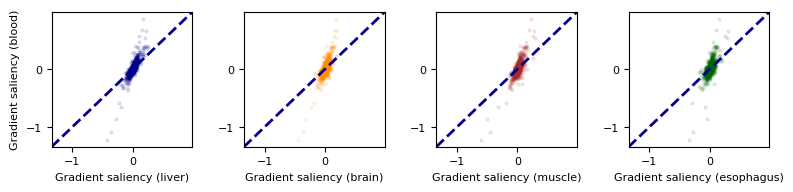

 - (Differential gradient score of blood against 'mean') -


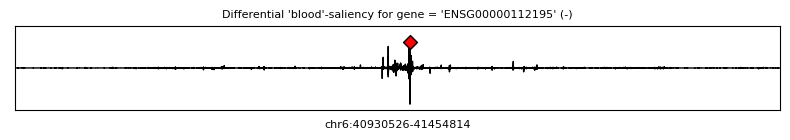

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 270608
 - max_pos (abs) = 41201134
 - chr6:41201038-41201230
blood


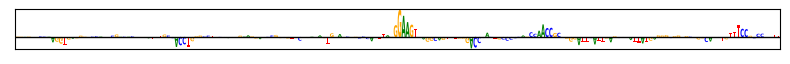

liver


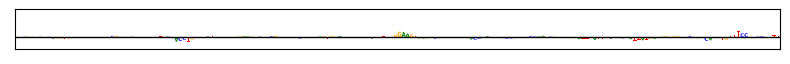

brain


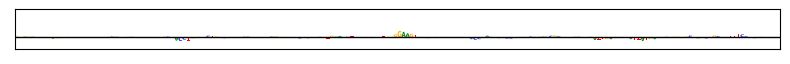

muscle


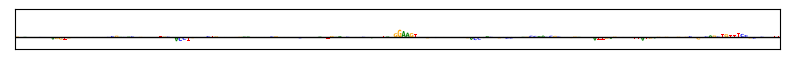

esophagus


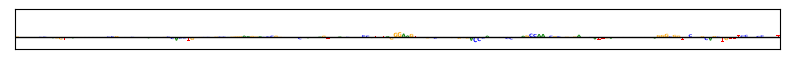

--------------------

-- Example = 10 --
 - ENSG00000255398(-)
 - chr12:122453638-122977926
 -- min_val = -0.9014
 -- max_val = 1.314
 - (Gradient score profiles per tissue) - 


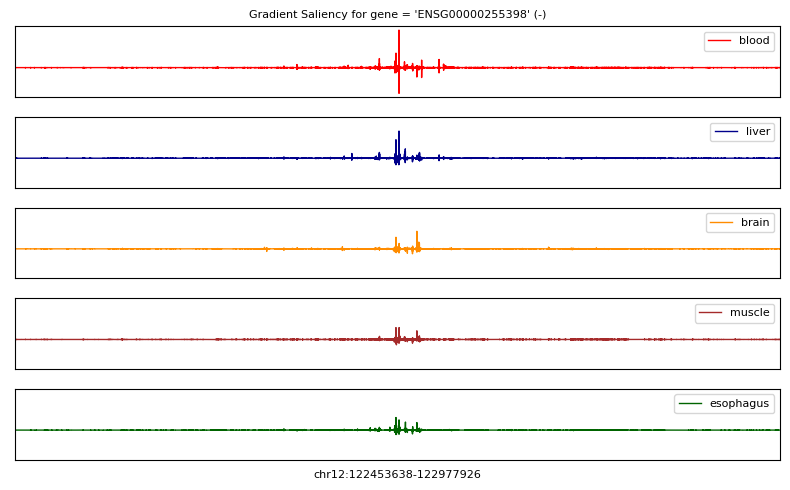

 - (Gradient score comparison against 'blood') - 
liver (r = 0.471)
brain (r = 0.128)
muscle (r = 0.372)
esophagus (r = 0.33)


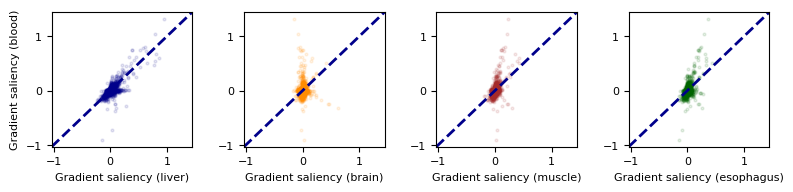

 - (Differential gradient score of blood against 'mean') -


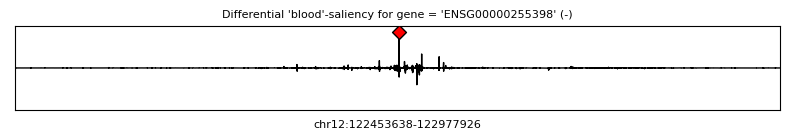

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263217
 - max_pos (abs) = 122716855
 - chr12:122716759-122716951
blood


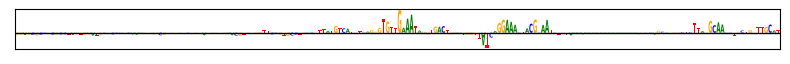

liver


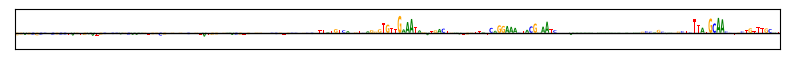

brain


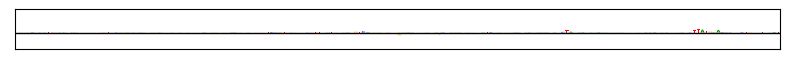

muscle


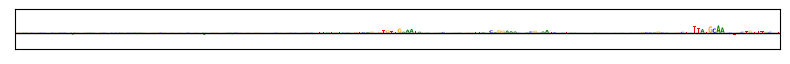

esophagus


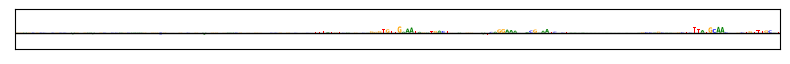

--------------------

-- Example = 11 --
 - ENSG00000158578(-)
 - chrX:54755896-55280184
 -- min_val = -0.49
 -- max_val = 0.3967
 - (Gradient score profiles per tissue) - 


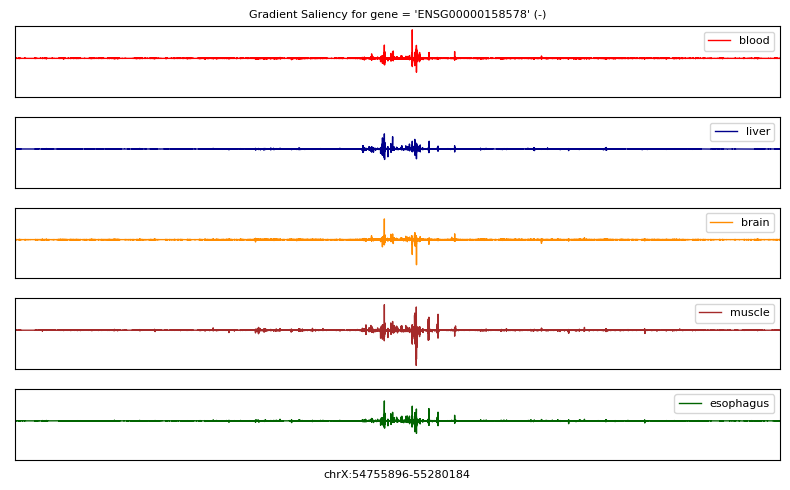

 - (Gradient score comparison against 'blood') - 
liver (r = 0.214)
brain (r = 0.251)
muscle (r = 0.312)
esophagus (r = 0.545)


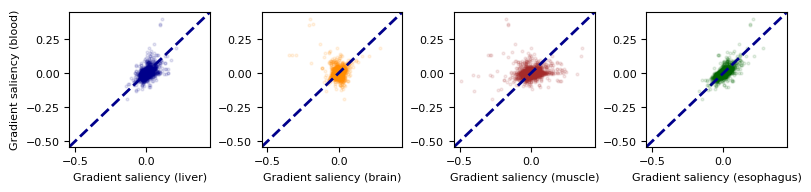

 - (Differential gradient score of blood against 'mean') -


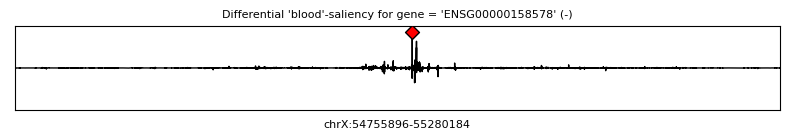

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272303
 - max_pos (abs) = 55028199
 - chrX:55028103-55028295
blood


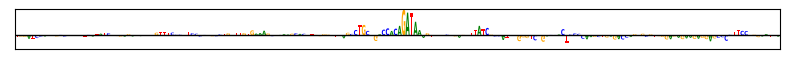

liver


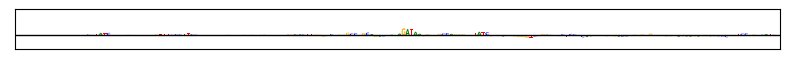

brain


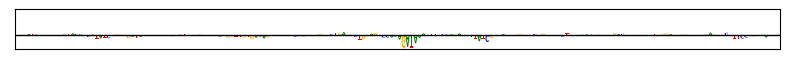

muscle


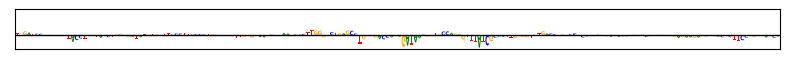

esophagus


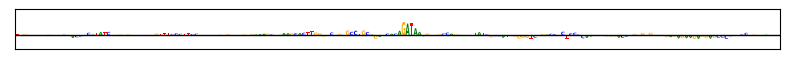

--------------------

-- Example = 12 --
 - ENSG00000124731(-)
 - chr6:41014251-41538539
 -- min_val = -1.457
 -- max_val = 2.768
 - (Gradient score profiles per tissue) - 


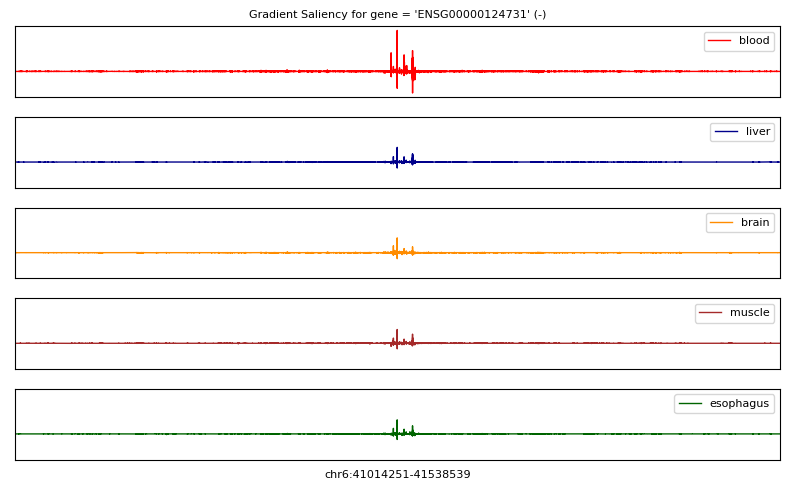

 - (Gradient score comparison against 'blood') - 
liver (r = 0.517)
brain (r = 0.405)
muscle (r = 0.4)
esophagus (r = 0.512)


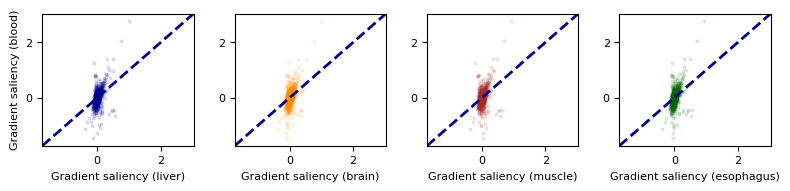

 - (Differential gradient score of blood against 'mean') -


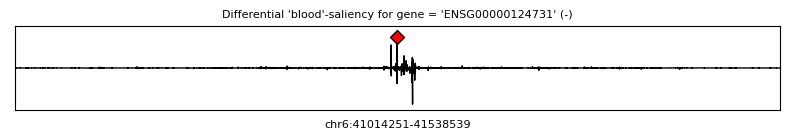

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261978
 - max_pos (abs) = 41276229
 - chr6:41276133-41276325
blood


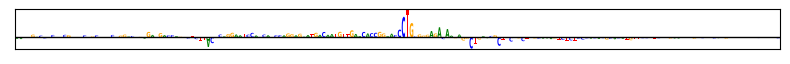

liver


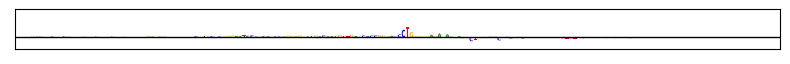

brain


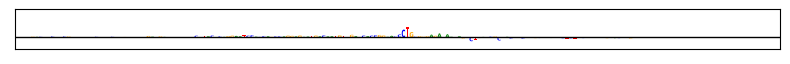

muscle


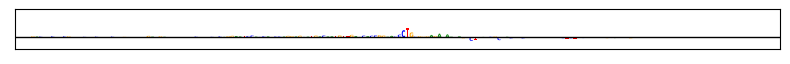

esophagus


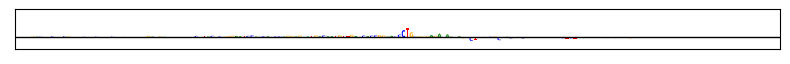

--------------------

-- Example = 13 --
 - ENSG00000164821(-)
 - chr8:6674413-7198701
 -- min_val = -0.885
 -- max_val = 2.443
 - (Gradient score profiles per tissue) - 


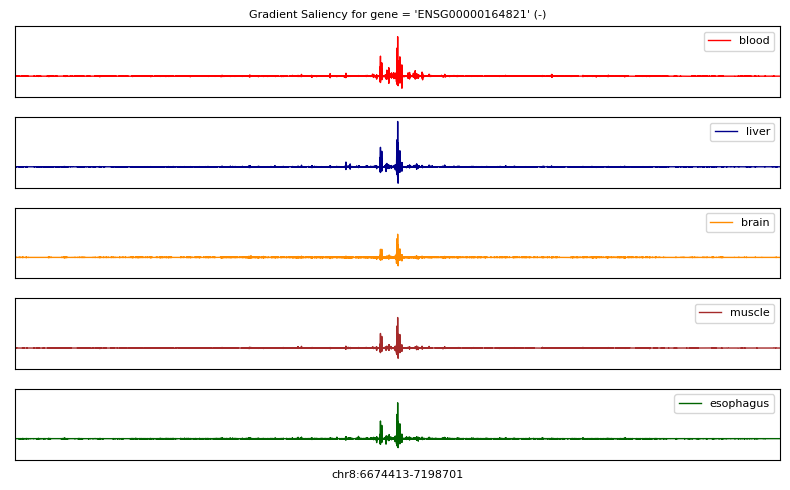

 - (Gradient score comparison against 'blood') - 
liver (r = 0.663)
brain (r = 0.507)
muscle (r = 0.669)
esophagus (r = 0.721)


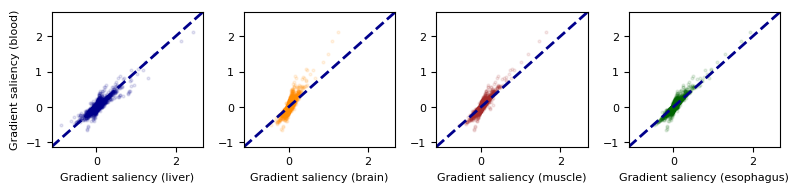

 - (Differential gradient score of blood against 'mean') -


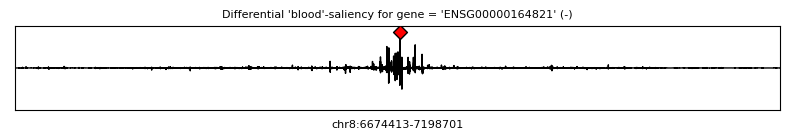

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263913
 - max_pos (abs) = 6938326
 - chr8:6938230-6938422
blood


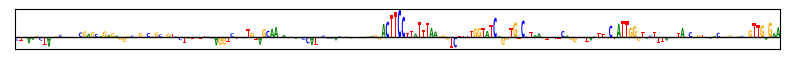

liver


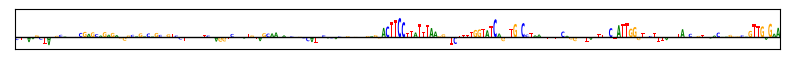

brain


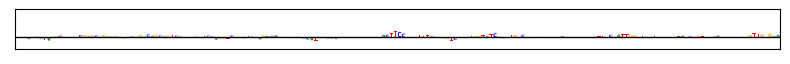

muscle


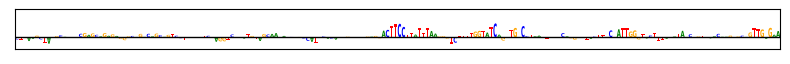

esophagus


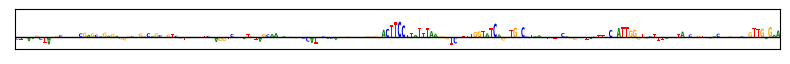

--------------------

-- Example = 14 --
 - ENSG00000183019(+)
 - chr19:7416744-7941032
 -- min_val = -1.334
 -- max_val = 2.527
 - (Gradient score profiles per tissue) - 


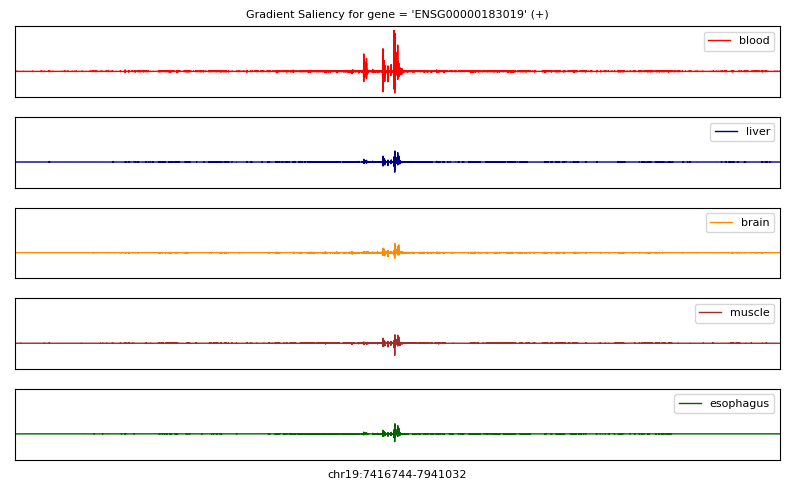

 - (Gradient score comparison against 'blood') - 
liver (r = 0.547)
brain (r = 0.359)
muscle (r = 0.348)
esophagus (r = 0.528)


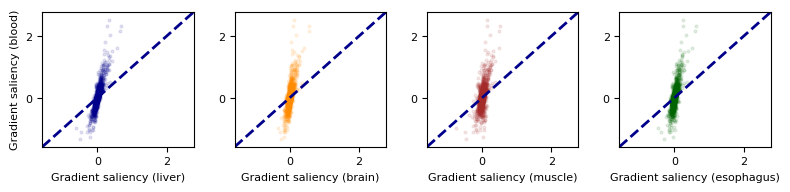

 - (Differential gradient score of blood against 'mean') -


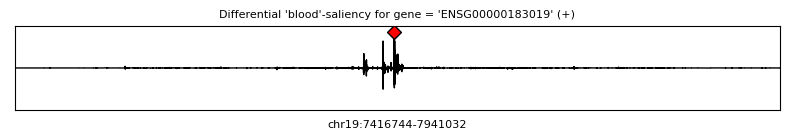

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259824
 - max_pos (abs) = 7676568
 - chr19:7676472-7676664
blood


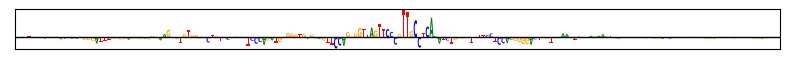

liver


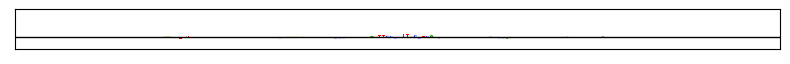

brain


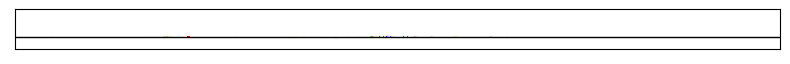

muscle


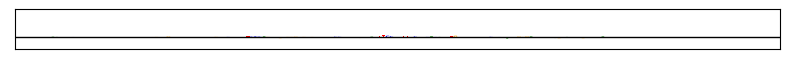

esophagus


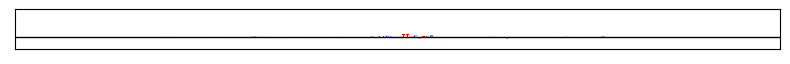

--------------------

-- Example = 15 --
 - ENSG00000105205(-)
 - chr19:39471649-39995937
 -- min_val = -1.065
 -- max_val = 1.239
 - (Gradient score profiles per tissue) - 


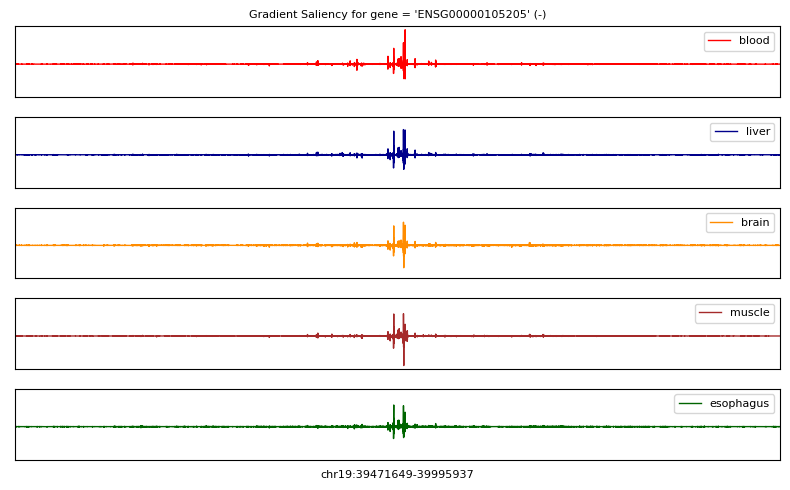

 - (Gradient score comparison against 'blood') - 
liver (r = 0.572)
brain (r = 0.56)
muscle (r = 0.447)
esophagus (r = 0.475)


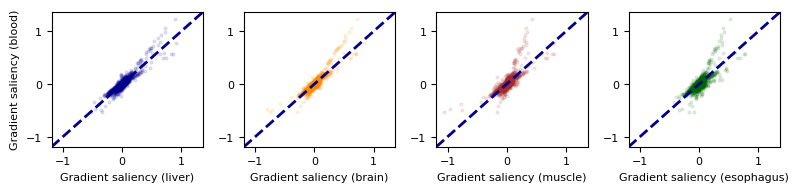

 - (Differential gradient score of blood against 'mean') -


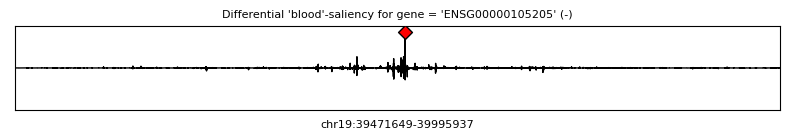

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 267413
 - max_pos (abs) = 39739062
 - chr19:39738966-39739158
blood


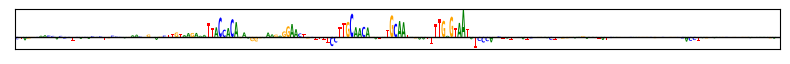

liver


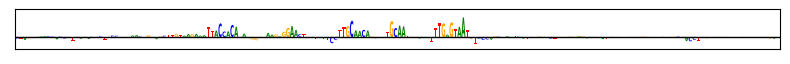

brain


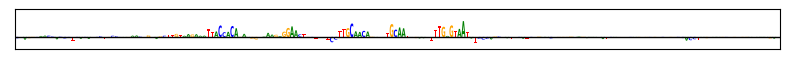

muscle


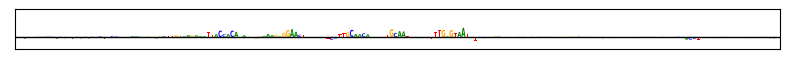

esophagus


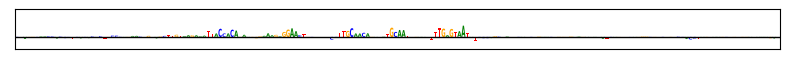

--------------------

-- Example = 16 --
 - ENSG00000170956(+)
 - chr19:41542701-42066989
 -- min_val = -0.3848
 -- max_val = 1.068
 - (Gradient score profiles per tissue) - 


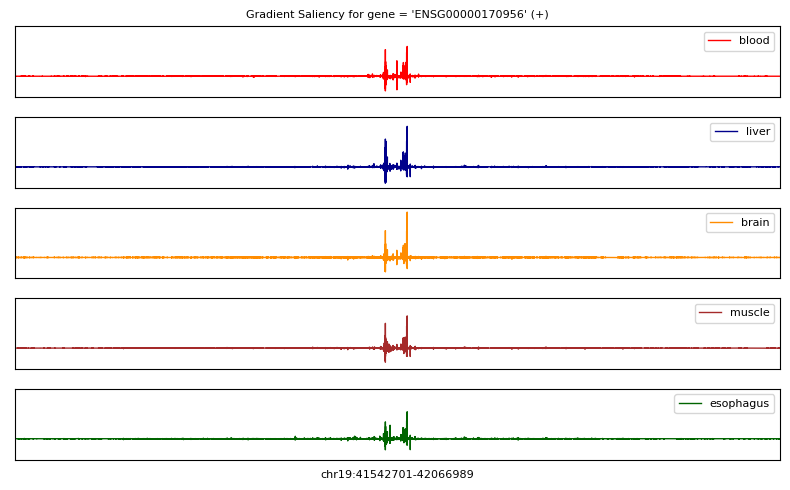

 - (Gradient score comparison against 'blood') - 
liver (r = 0.382)
brain (r = 0.452)
muscle (r = 0.421)
esophagus (r = 0.405)


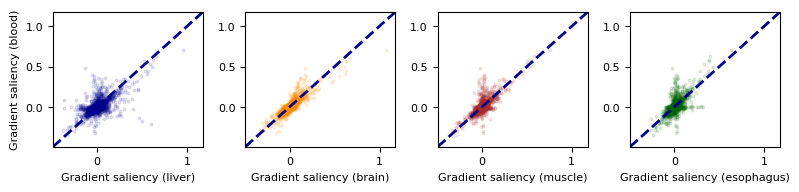

 - (Differential gradient score of blood against 'mean') -


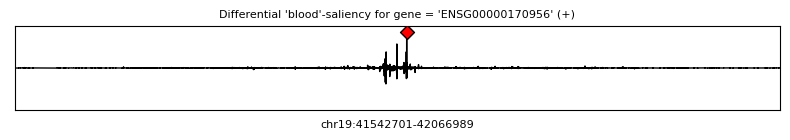

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 268475
 - max_pos (abs) = 41811176
 - chr19:41811080-41811272
blood


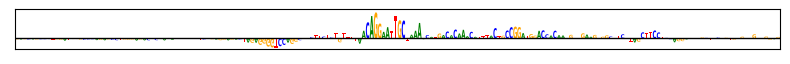

liver


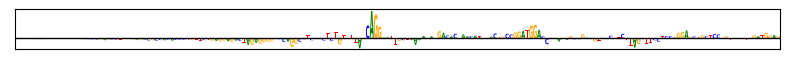

brain


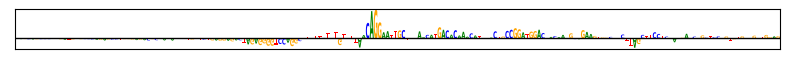

muscle


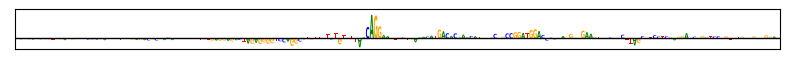

esophagus


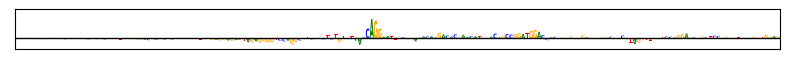

--------------------

-- Example = 17 --
 - ENSG00000163421(-)
 - chr3:71512521-72036809
 -- min_val = -0.6665
 -- max_val = 1.712
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


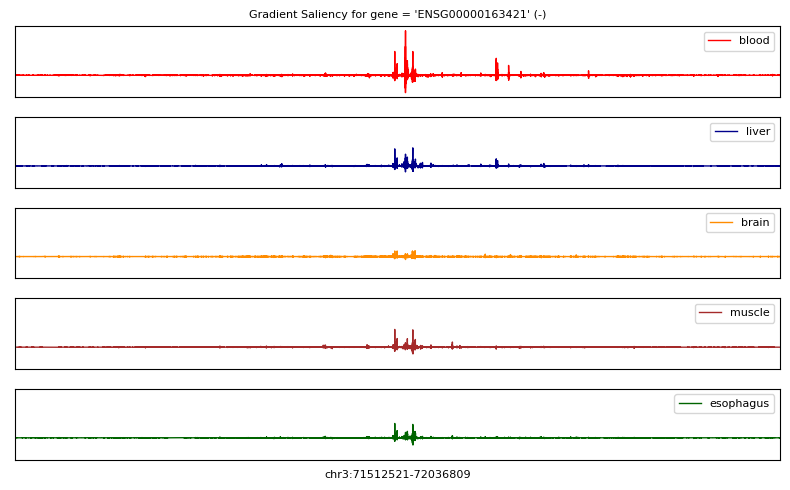

 - (Gradient score comparison against 'blood') - 
liver (r = 0.415)
brain (r = 0.086)
muscle (r = 0.171)
esophagus (r = 0.31)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


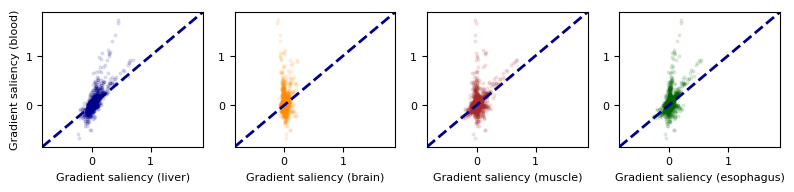

 - (Differential gradient score of blood against 'mean') -


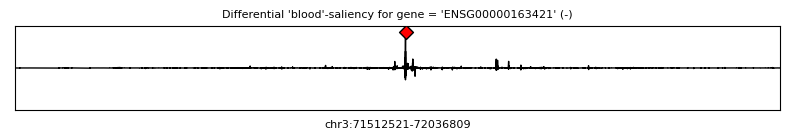

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 267679
 - max_pos (abs) = 71780200
 - chr3:71780104-71780296
blood


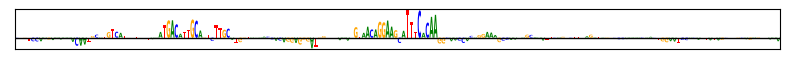

liver


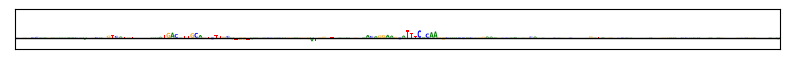

brain


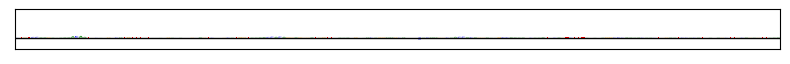

muscle


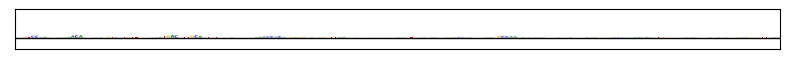

esophagus


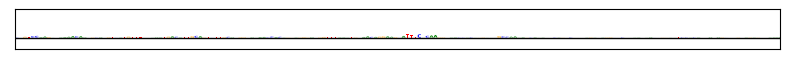

--------------------

-- Example = 18 --
 - ENSG00000131355(-)
 - chr19:14380540-14904828
 -- min_val = -0.4363
 -- max_val = 1.104
 - (Gradient score profiles per tissue) - 


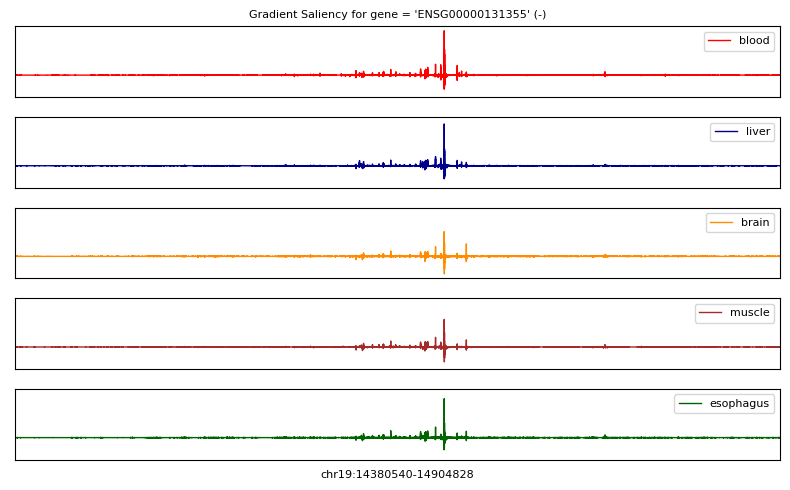

 - (Gradient score comparison against 'blood') - 
liver (r = 0.493)
brain (r = 0.376)
muscle (r = 0.446)
esophagus (r = 0.552)


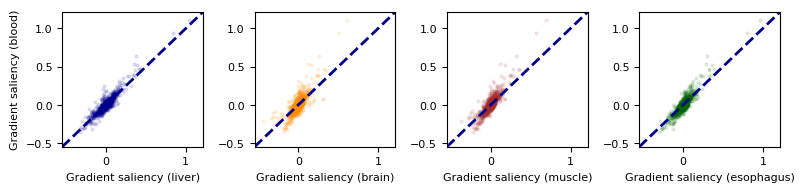

 - (Differential gradient score of blood against 'mean') -


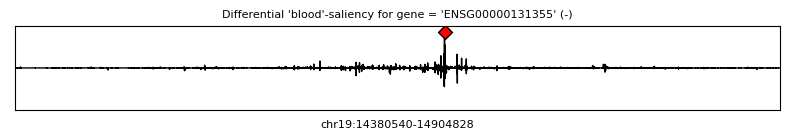

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 294399
 - max_pos (abs) = 14674939
 - chr19:14674843-14675035
blood


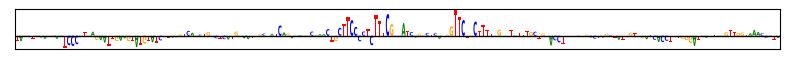

liver


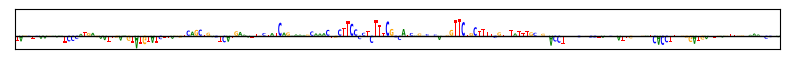

brain


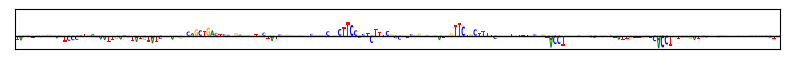

muscle


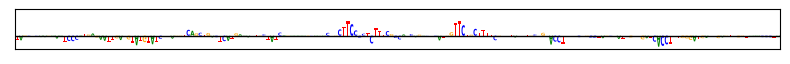

esophagus


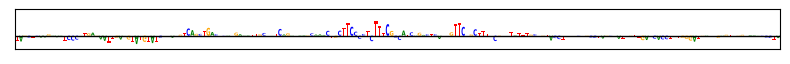

--------------------

-- Example = 19 --
 - ENSG00000128383(+)
 - chr22:38699581-39223869
 -- min_val = -0.641
 -- max_val = 2.65
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


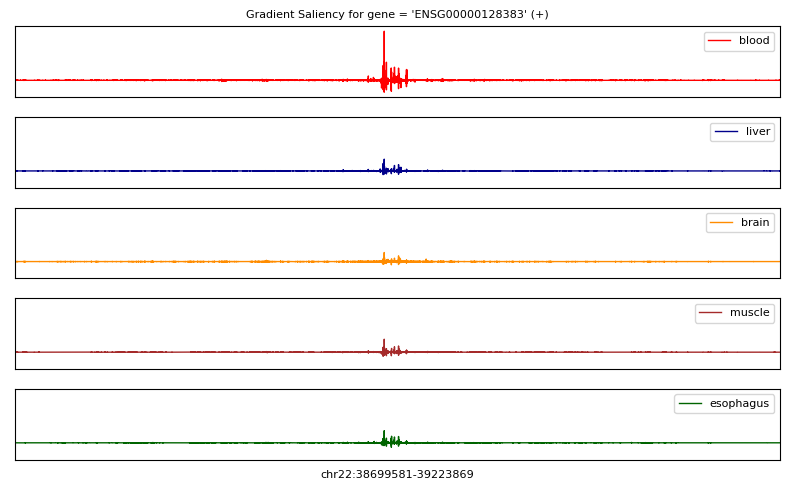

 - (Gradient score comparison against 'blood') - 
liver (r = 0.365)
brain (r = 0.35)
muscle (r = 0.402)
esophagus (r = 0.432)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


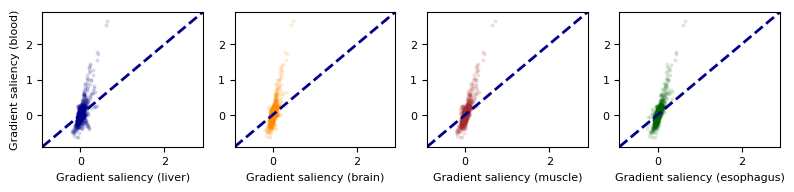

 - (Differential gradient score of blood against 'mean') -


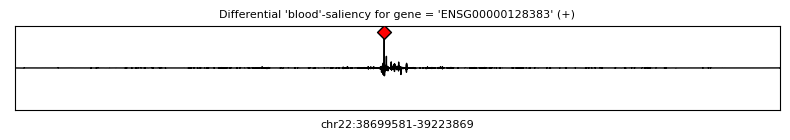

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253108
 - max_pos (abs) = 38952689
 - chr22:38952593-38952785
blood


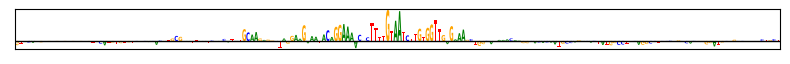

liver


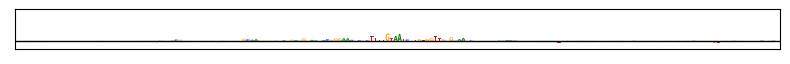

brain


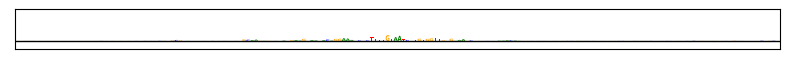

muscle


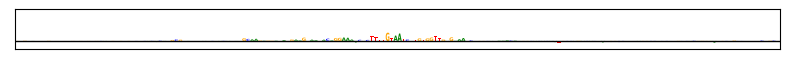

esophagus


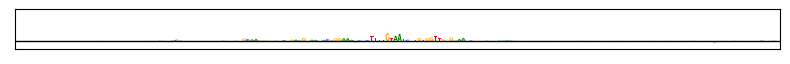

--------------------

-- Example = 20 --
 - ENSG00000186431(+)
 - chr19:54626701-55150989
 -- min_val = -1.631
 -- max_val = 2.191
 - (Gradient score profiles per tissue) - 


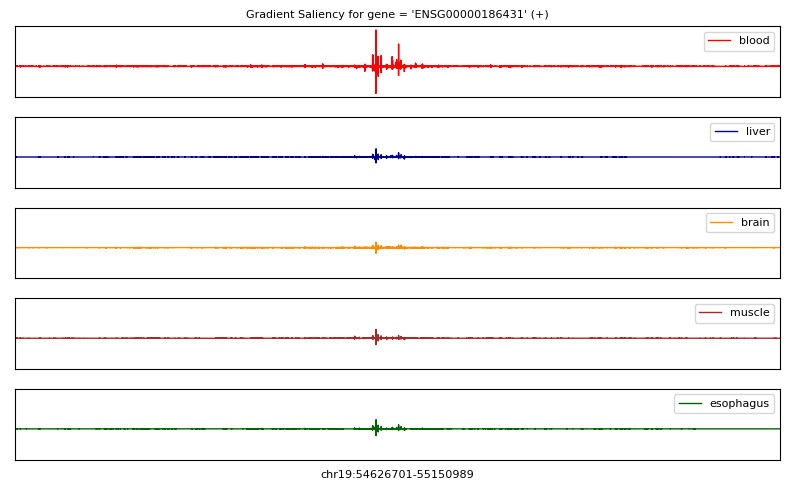

 - (Gradient score comparison against 'blood') - 
liver (r = 0.534)
brain (r = 0.327)
muscle (r = 0.39)
esophagus (r = 0.57)


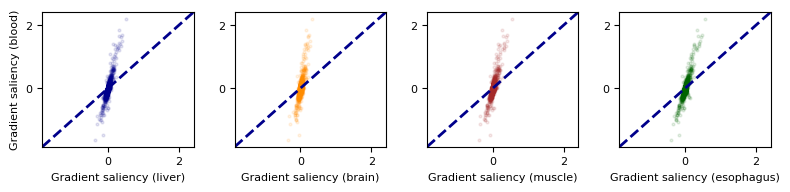

 - (Differential gradient score of blood against 'mean') -


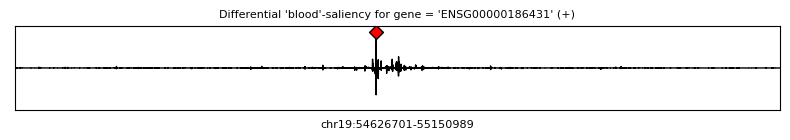

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 247457
 - max_pos (abs) = 54874158
 - chr19:54874062-54874254
blood


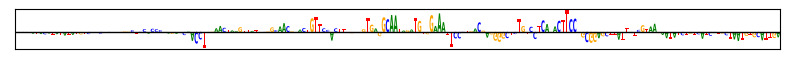

liver


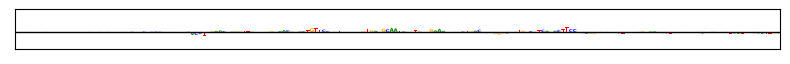

brain


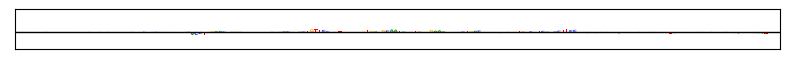

muscle


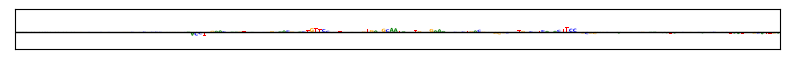

esophagus


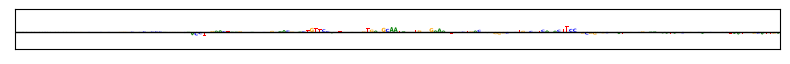

--------------------

-- Example = 21 --
 - ENSG00000008438(-)
 - chr19:45758818-46283106
 -- min_val = -2.086
 -- max_val = 3.18
 - (Gradient score profiles per tissue) - 


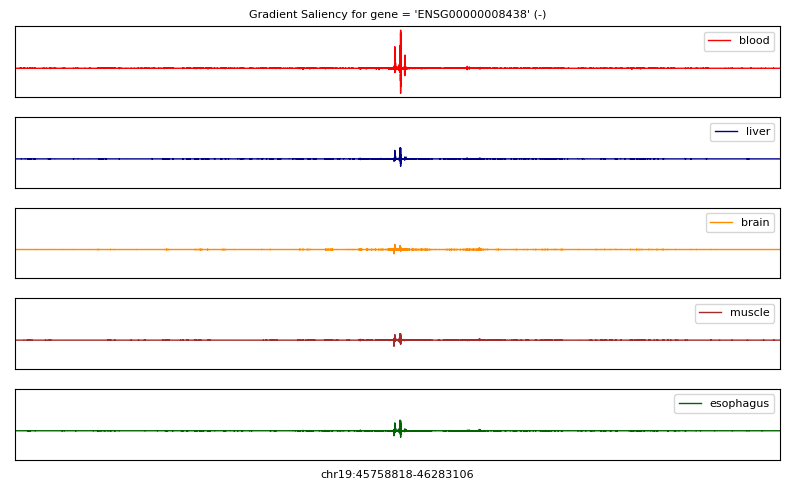

 - (Gradient score comparison against 'blood') - 
liver (r = 0.428)
brain (r = 0.215)
muscle (r = 0.277)
esophagus (r = 0.464)


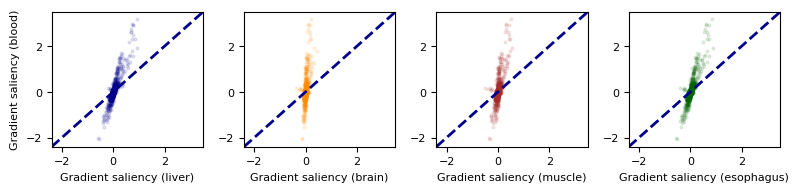

 - (Differential gradient score of blood against 'mean') -


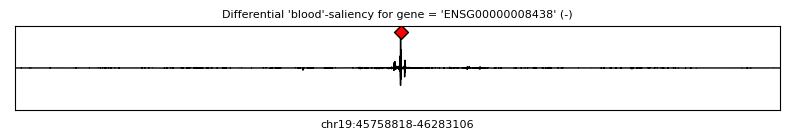

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264300
 - max_pos (abs) = 46023118
 - chr19:46023022-46023214
blood


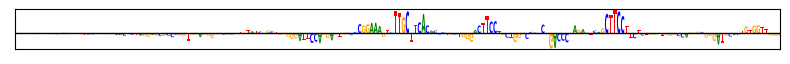

liver


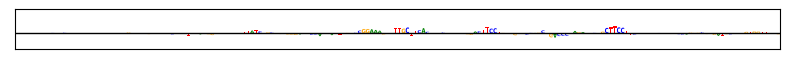

brain


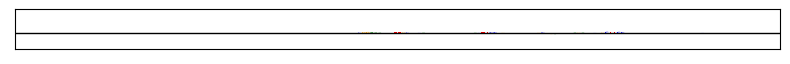

muscle


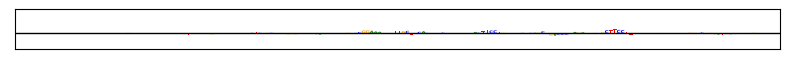

esophagus


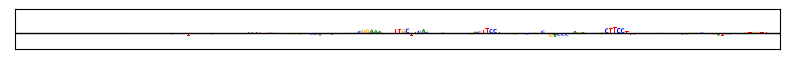

--------------------

-- Example = 22 --
 - ENSG00000166947(-)
 - chr15:42946773-43471061
 -- min_val = -0.4905
 -- max_val = 1.395
 - (Gradient score profiles per tissue) - 


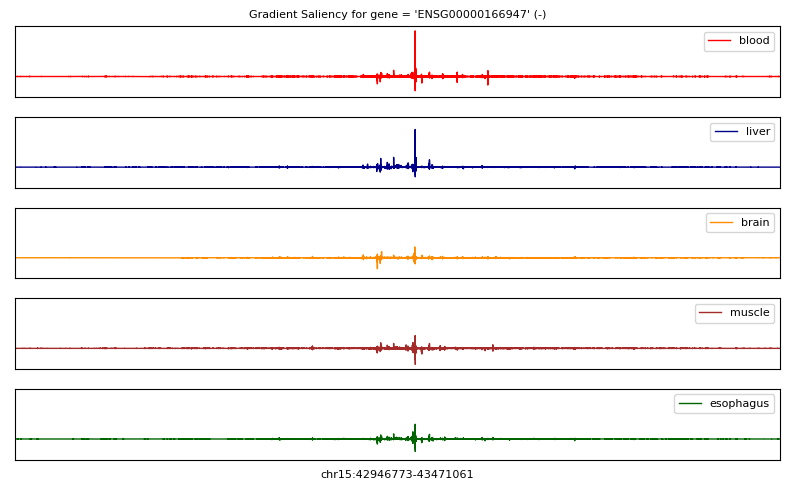

 - (Gradient score comparison against 'blood') - 
liver (r = 0.331)
brain (r = 0.175)
muscle (r = 0.217)
esophagus (r = 0.426)


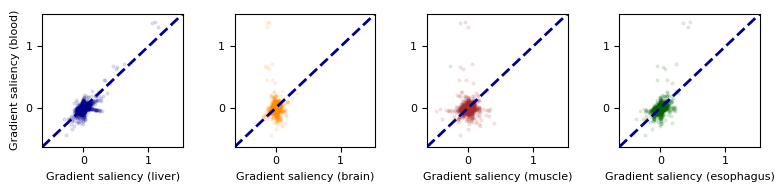

 - (Differential gradient score of blood against 'mean') -


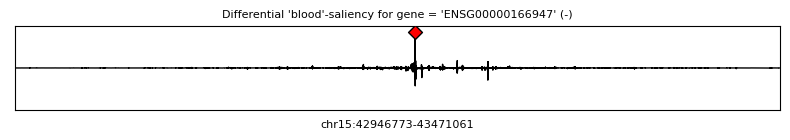

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 274303
 - max_pos (abs) = 43221076
 - chr15:43220980-43221172
blood


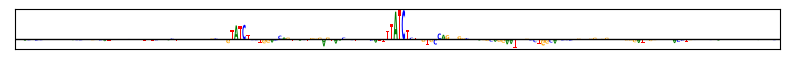

liver


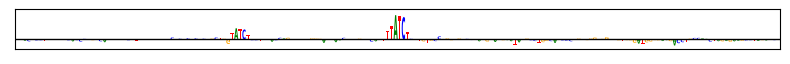

brain


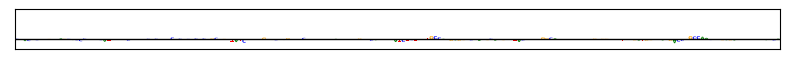

muscle


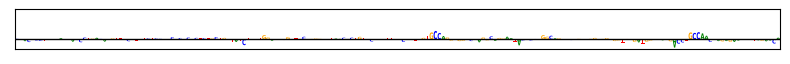

esophagus


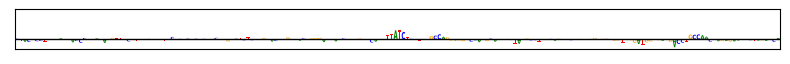

--------------------

-- Example = 23 --
 - ENSG00000163464(-)
 - chr2:217901962-218426250
 -- min_val = -1.229
 -- max_val = 1.04
 - (Gradient score profiles per tissue) - 


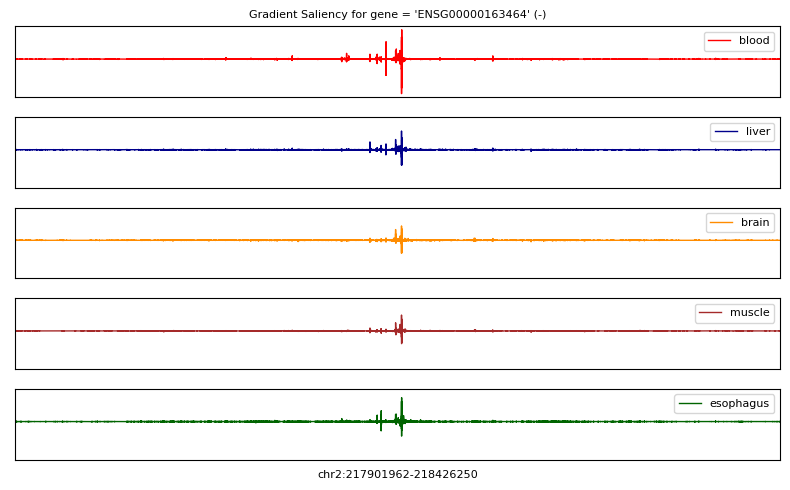

 - (Gradient score comparison against 'blood') - 
liver (r = 0.463)
brain (r = 0.274)
muscle (r = 0.276)
esophagus (r = 0.105)


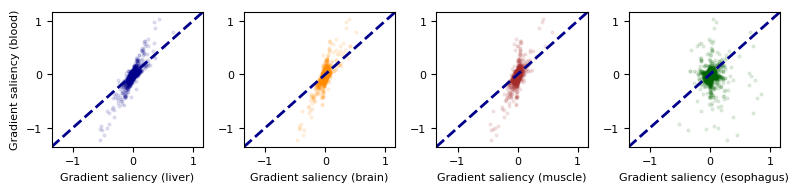

 - (Differential gradient score of blood against 'mean') -


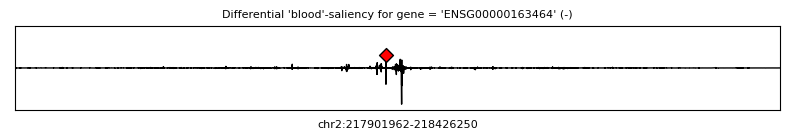

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254352
 - max_pos (abs) = 218156314
 - chr2:218156218-218156410
blood


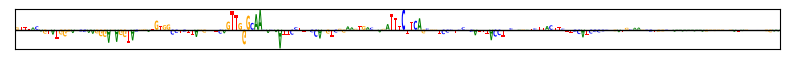

liver


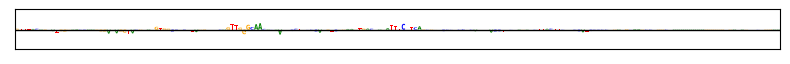

brain


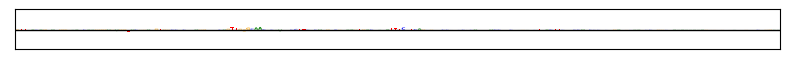

muscle


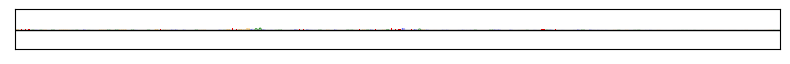

esophagus


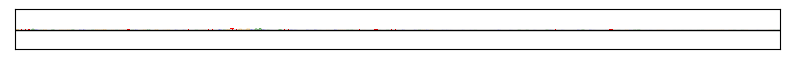

--------------------

-- Example = 24 --
 - ENSG00000173535(+)
 - chr8:22851573-23375861
 -- min_val = -0.556
 -- max_val = 1.465
 - (Gradient score profiles per tissue) - 


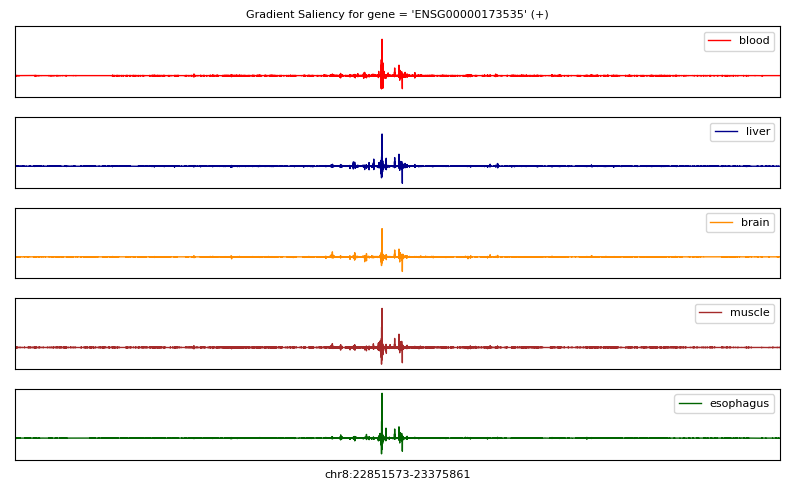

 - (Gradient score comparison against 'blood') - 
liver (r = 0.511)
brain (r = 0.414)
muscle (r = 0.397)
esophagus (r = 0.459)


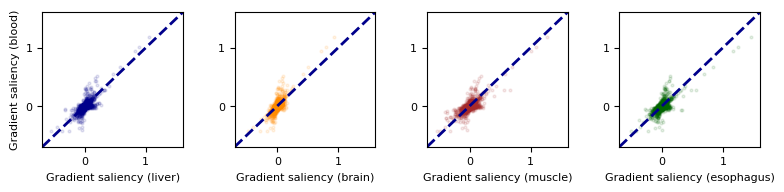

 - (Differential gradient score of blood against 'mean') -


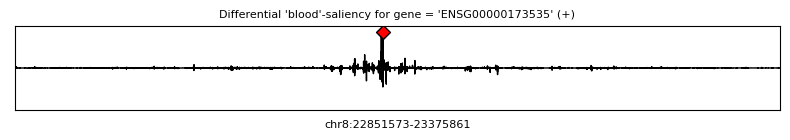

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 252047
 - max_pos (abs) = 23103620
 - chr8:23103524-23103716
blood


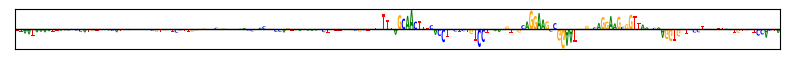

liver


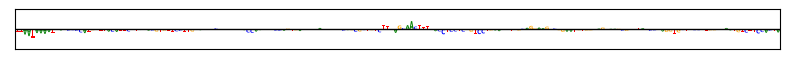

brain


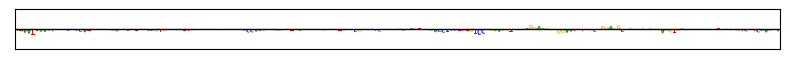

muscle


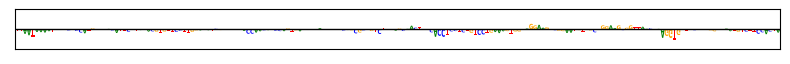

esophagus


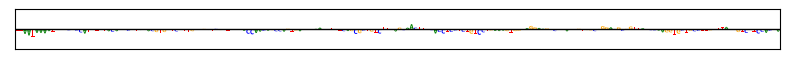

--------------------

-- Example = 25 --
 - ENSG00000104918(+)
 - chr19:7407705-7931993
 -- min_val = -1.053
 -- max_val = 1.289
 - (Gradient score profiles per tissue) - 


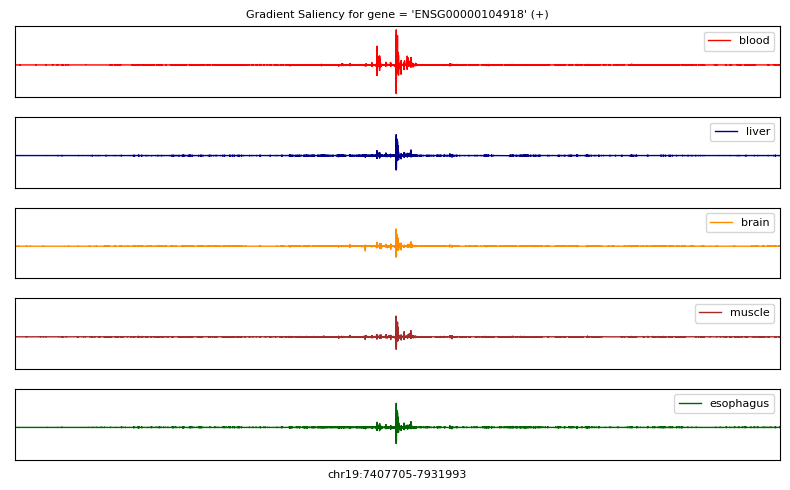

 - (Gradient score comparison against 'blood') - 
liver (r = 0.412)
brain (r = 0.243)
muscle (r = 0.221)
esophagus (r = 0.407)


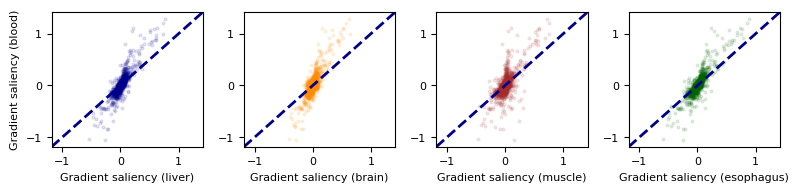

 - (Differential gradient score of blood against 'mean') -


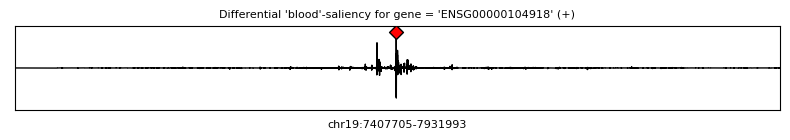

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261328
 - max_pos (abs) = 7669033
 - chr19:7668937-7669129
blood


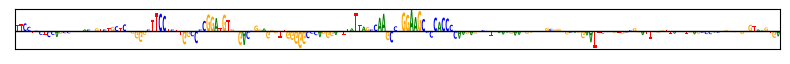

liver


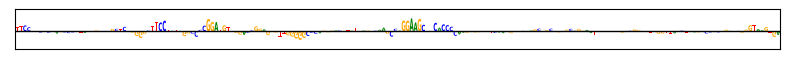

brain


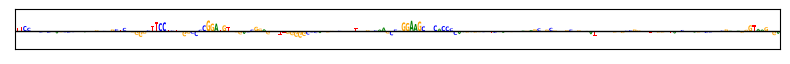

muscle


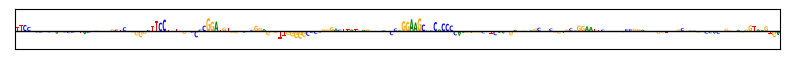

esophagus


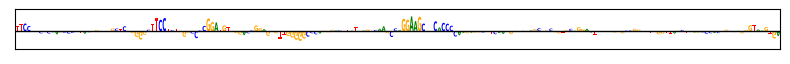

--------------------

-- Example = 26 --
 - ENSG00000213934(-)
 - chr11:4986998-5511286
 -- min_val = -0.4287
 -- max_val = 0.9126
 - (Gradient score profiles per tissue) - 


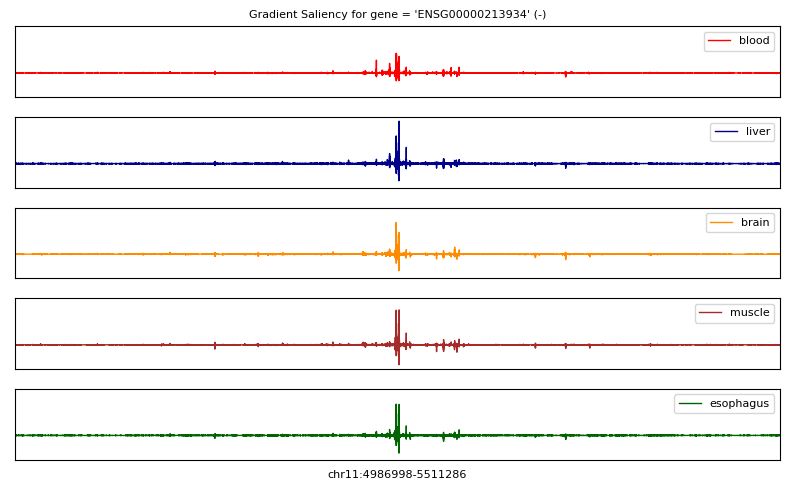

 - (Gradient score comparison against 'blood') - 
liver (r = 0.501)
brain (r = 0.456)
muscle (r = 0.502)
esophagus (r = 0.614)


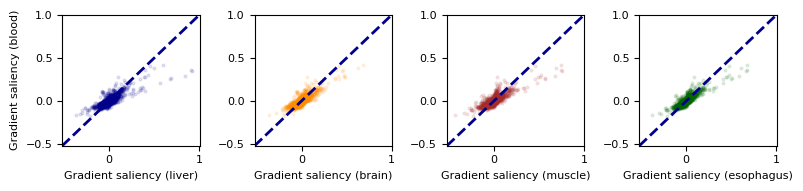

 - (Differential gradient score of blood against 'mean') -


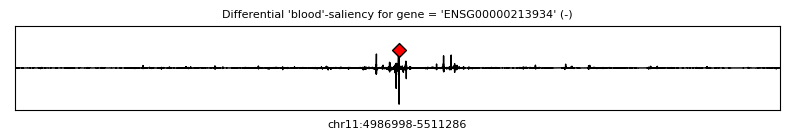

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263037
 - max_pos (abs) = 5250035
 - chr11:5249939-5250131
blood


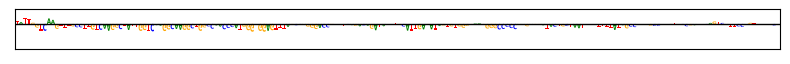

liver


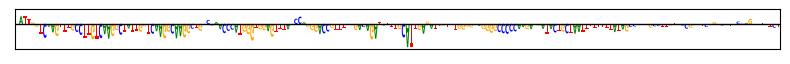

brain


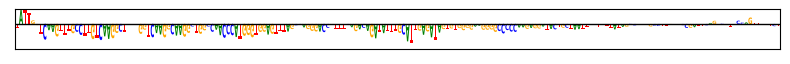

muscle


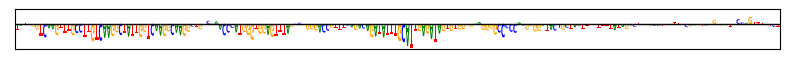

esophagus


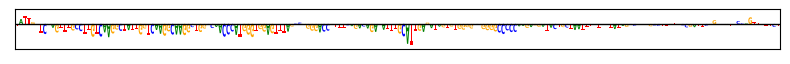

--------------------

-- Example = 27 --
 - ENSG00000196565(-)
 - chr11:4991922-5516210
 -- min_val = -0.4026
 -- max_val = 1.054
 - (Gradient score profiles per tissue) - 


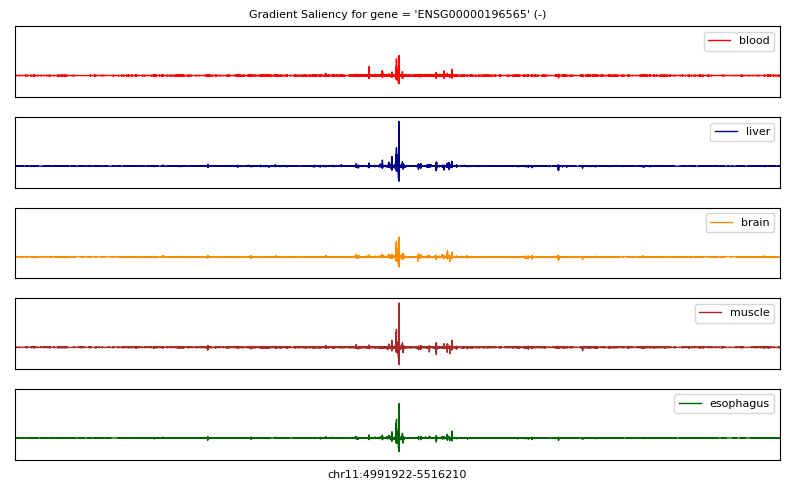

 - (Gradient score comparison against 'blood') - 
liver (r = 0.478)
brain (r = 0.454)
muscle (r = 0.511)
esophagus (r = 0.645)


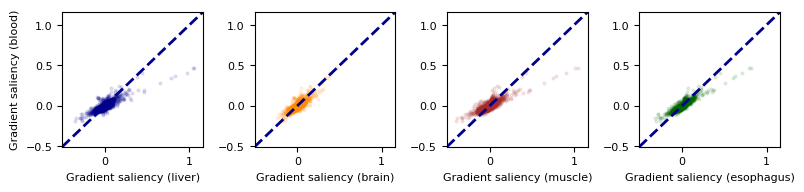

 - (Differential gradient score of blood against 'mean') -


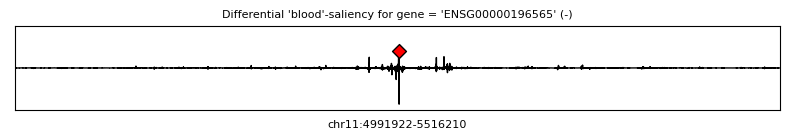

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262961
 - max_pos (abs) = 5254883
 - chr11:5254787-5254979
blood


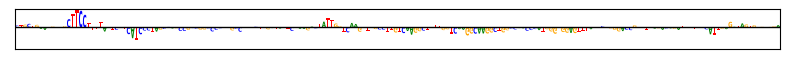

liver


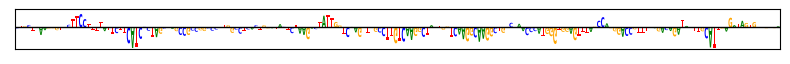

brain


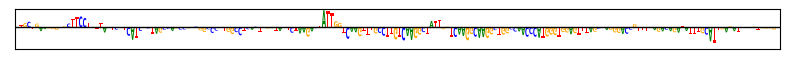

muscle


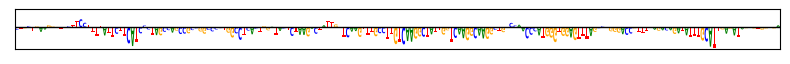

esophagus


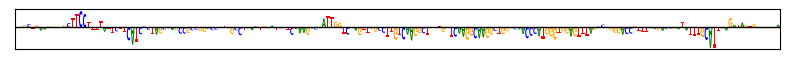

--------------------

-- Example = 28 --
 - ENSG00000169397(+)
 - chr14:20629815-21154103
 -- min_val = -0.6494
 -- max_val = 2.234
 - (Gradient score profiles per tissue) - 


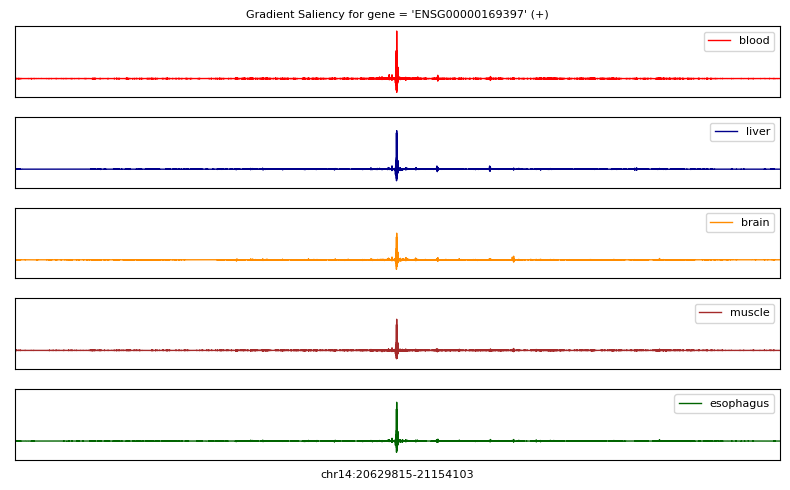

 - (Gradient score comparison against 'blood') - 
liver (r = 0.576)
brain (r = 0.402)
muscle (r = 0.478)
esophagus (r = 0.636)


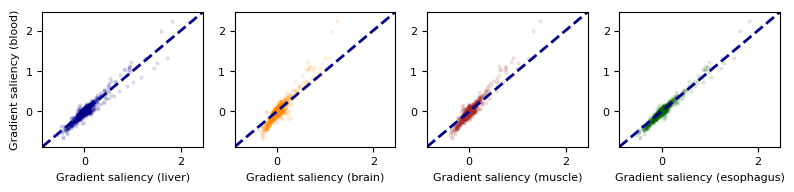

 - (Differential gradient score of blood against 'mean') -


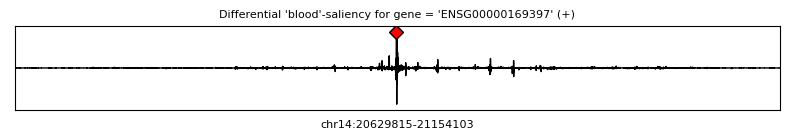

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261499
 - max_pos (abs) = 20891314
 - chr14:20891218-20891410
blood


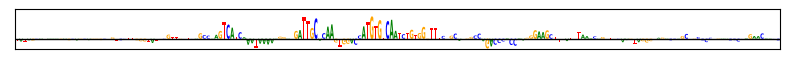

liver


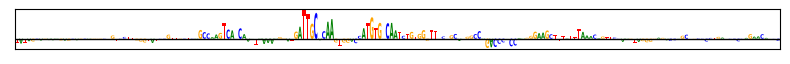

brain


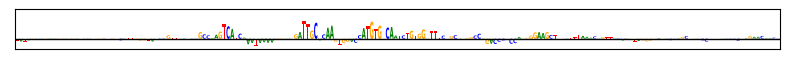

muscle


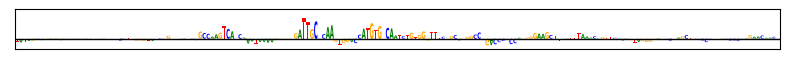

esophagus


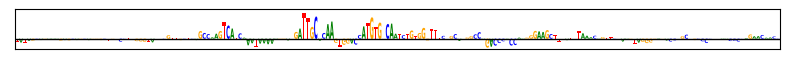

--------------------

-- Example = 29 --
 - ENSG00000182782(-)
 - chr12:122440180-122964468
 -- min_val = -0.2896
 -- max_val = 0.74
 - (Gradient score profiles per tissue) - 


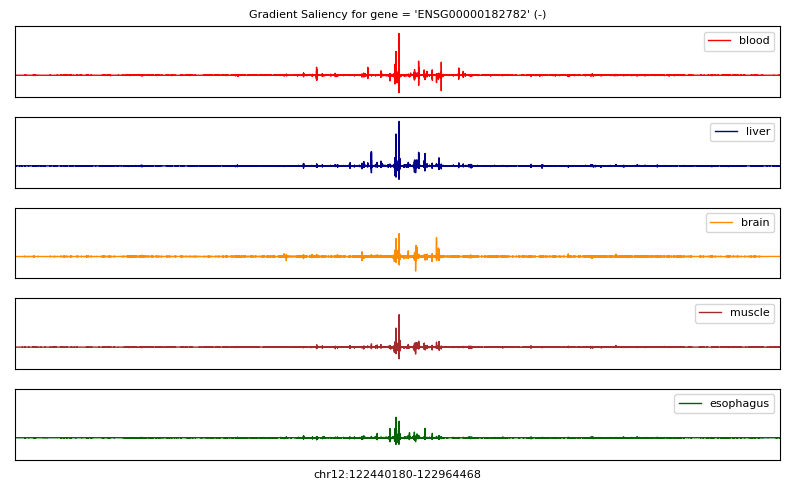

 - (Gradient score comparison against 'blood') - 
liver (r = 0.431)
brain (r = 0.112)
muscle (r = 0.346)
esophagus (r = 0.285)


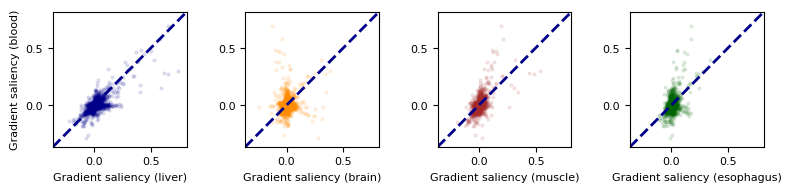

 - (Differential gradient score of blood against 'mean') -


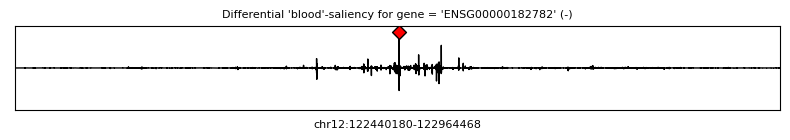

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263221
 - max_pos (abs) = 122703401
 - chr12:122703305-122703497
blood


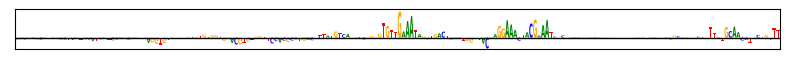

liver


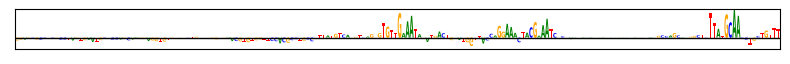

brain


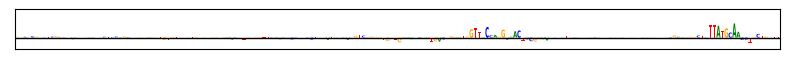

muscle


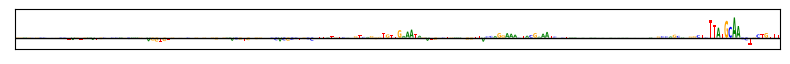

esophagus


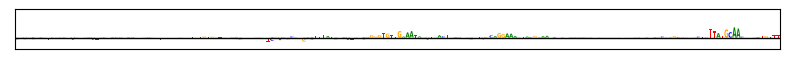

--------------------

-- Example = 30 --
 - ENSG00000163737(-)
 - chr4:73719167-74243455
 -- min_val = -0.411
 -- max_val = 0.96
 - (Gradient score profiles per tissue) - 


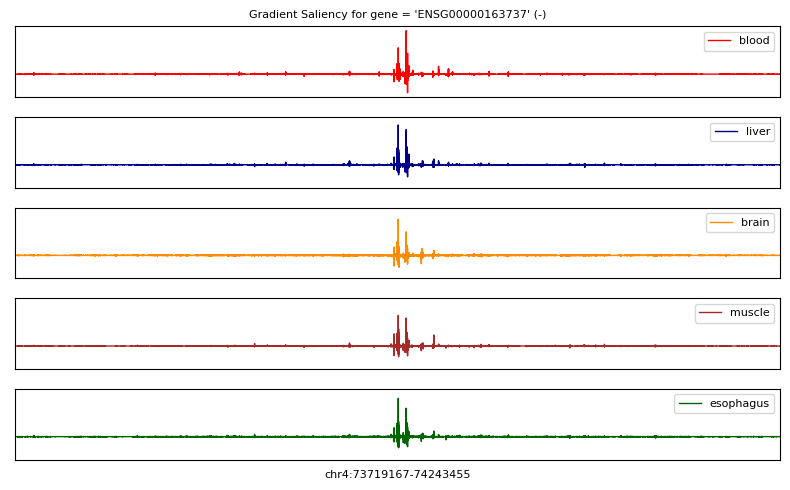

 - (Gradient score comparison against 'blood') - 
liver (r = 0.484)
brain (r = 0.288)
muscle (r = 0.311)
esophagus (r = 0.439)


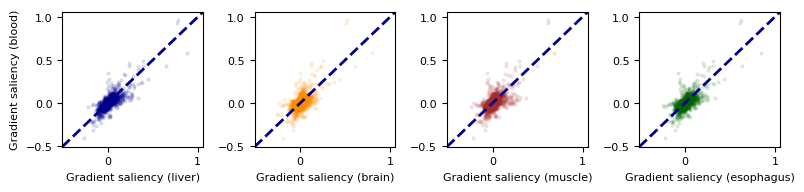

 - (Differential gradient score of blood against 'mean') -


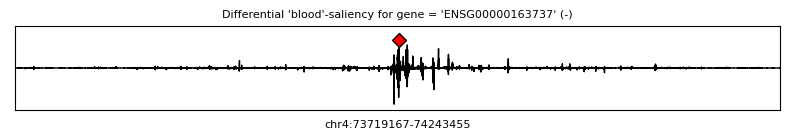

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263257
 - max_pos (abs) = 73982424
 - chr4:73982328-73982520
blood


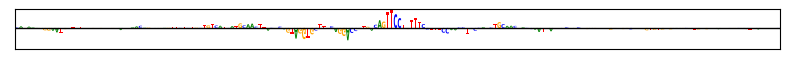

liver


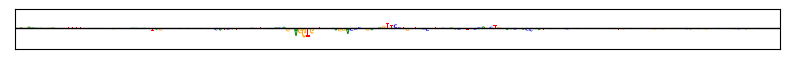

brain


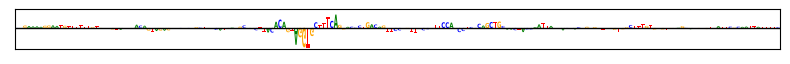

muscle


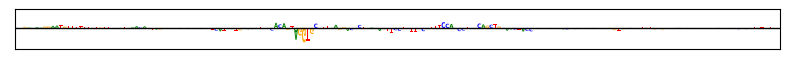

esophagus


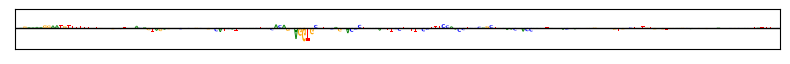

--------------------

-- Example = 31 --
 - ENSG00000159339(+)
 - chr1:17085559-17609847
 -- min_val = -2.875
 -- max_val = 2.506
 - (Gradient score profiles per tissue) - 


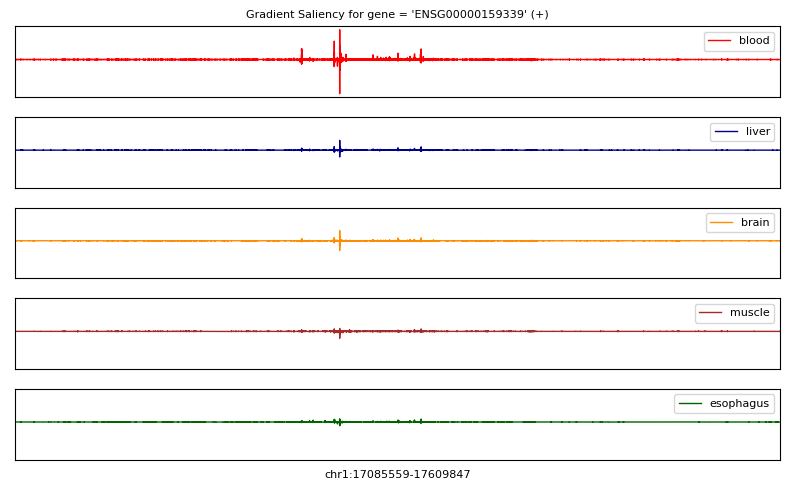

 - (Gradient score comparison against 'blood') - 
liver (r = 0.635)
brain (r = 0.483)
muscle (r = 0.456)
esophagus (r = 0.43)


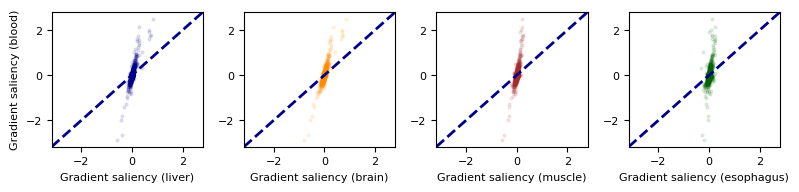

 - (Differential gradient score of blood against 'mean') -


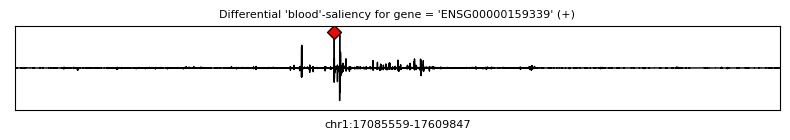

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 218859
 - max_pos (abs) = 17304418
 - chr1:17304322-17304514
blood


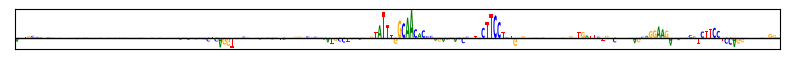

liver


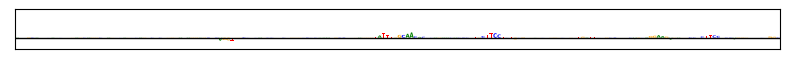

brain


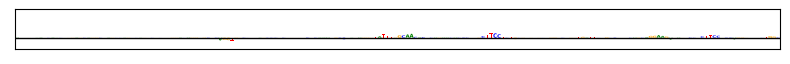

muscle


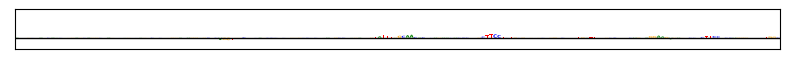

esophagus


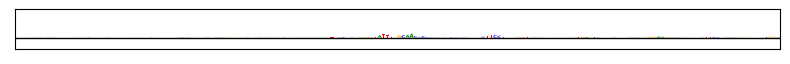

--------------------

-- Example = 32 --
 - ENSG00000204010(+)
 - chr10:89121851-89646139
 -- min_val = -0.9688
 -- max_val = 1.596
 - (Gradient score profiles per tissue) - 


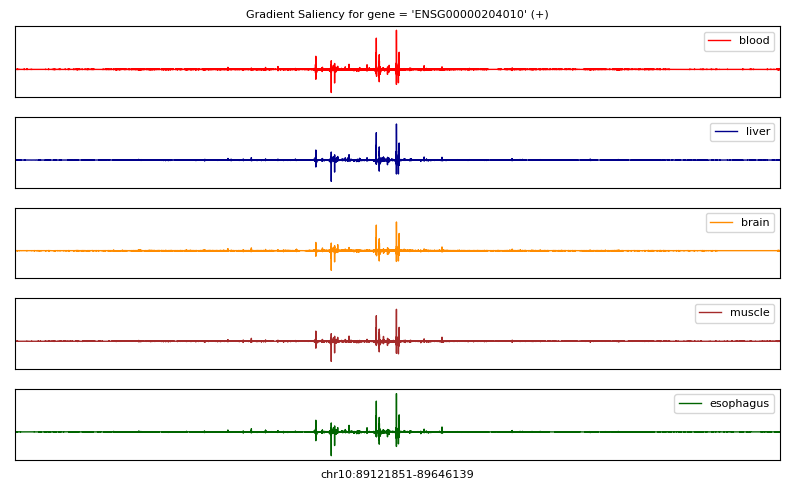

 - (Gradient score comparison against 'blood') - 
liver (r = 0.79)
brain (r = 0.75)
muscle (r = 0.772)
esophagus (r = 0.846)


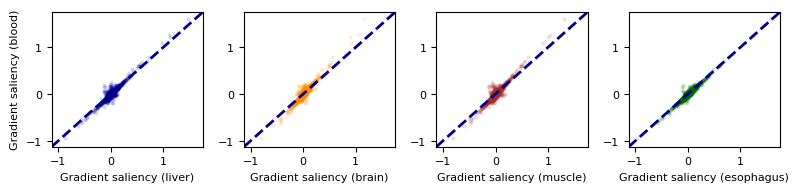

 - (Differential gradient score of blood against 'mean') -


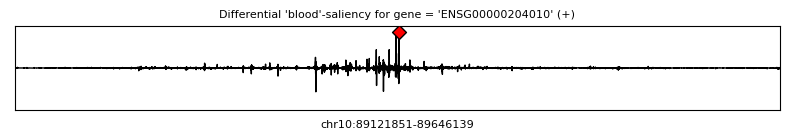

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263216
 - max_pos (abs) = 89385067
 - chr10:89384971-89385163
blood


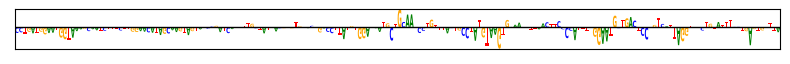

liver


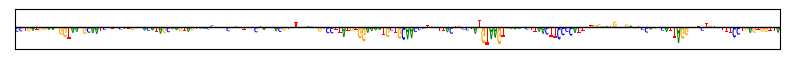

brain


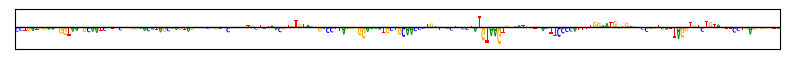

muscle


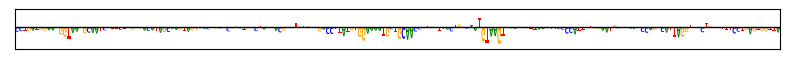

esophagus


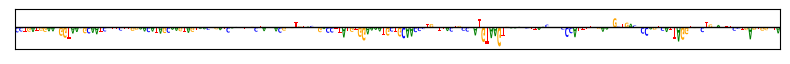

--------------------

-- Example = 33 --
 - ENSG00000134827(-)
 - chr11:59596271-60120559
 -- min_val = -1.652
 -- max_val = 1.982
 - (Gradient score profiles per tissue) - 


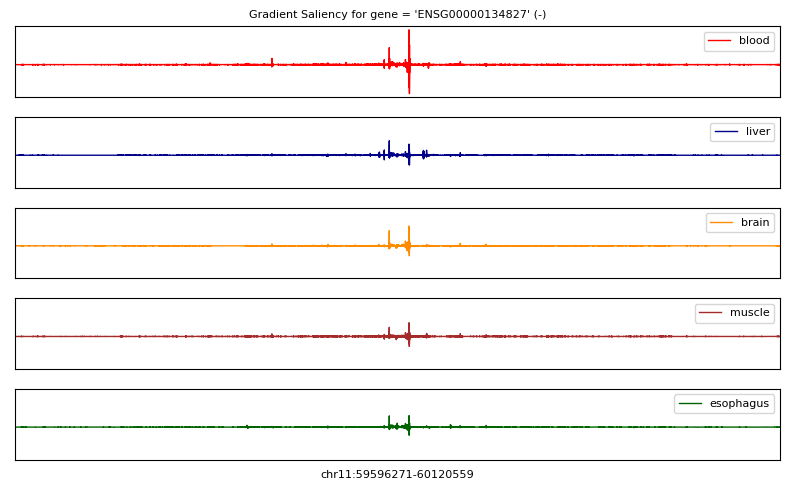

 - (Gradient score comparison against 'blood') - 
liver (r = 0.311)
brain (r = 0.432)
muscle (r = 0.424)
esophagus (r = 0.274)


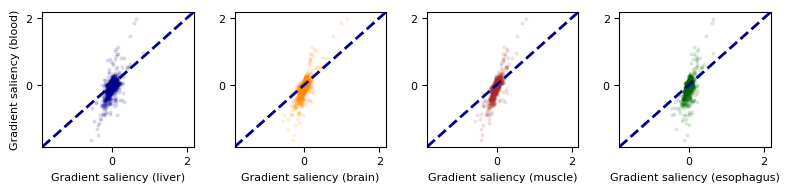

 - (Differential gradient score of blood against 'mean') -


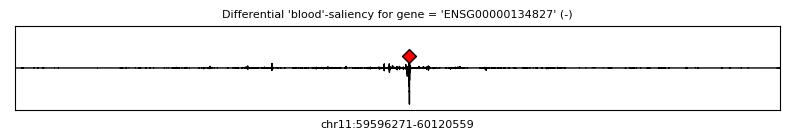

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 270120
 - max_pos (abs) = 59866391
 - chr11:59866295-59866487
blood


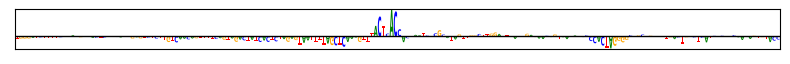

liver


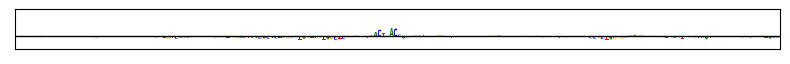

brain


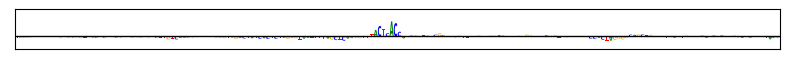

muscle


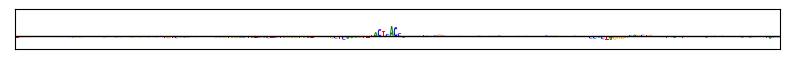

esophagus


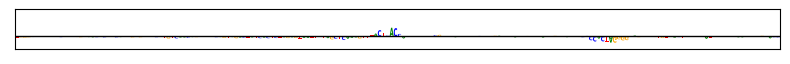

--------------------

-- Example = 34 --
 - ENSG00000123405(-)
 - chr12:54031914-54556202
 -- min_val = -1.297
 -- max_val = 1.383
 - (Gradient score profiles per tissue) - 


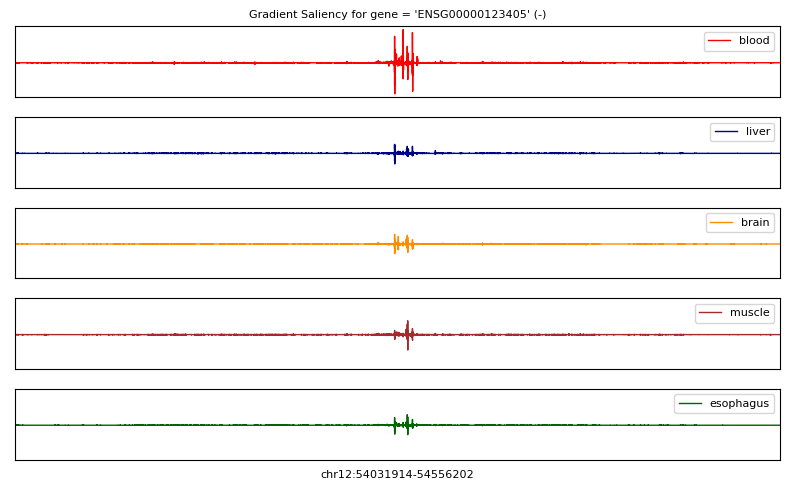

 - (Gradient score comparison against 'blood') - 
liver (r = 0.268)
brain (r = 0.259)
muscle (r = 0.188)
esophagus (r = 0.382)


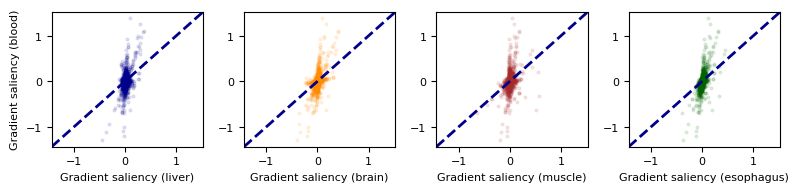

 - (Differential gradient score of blood against 'mean') -


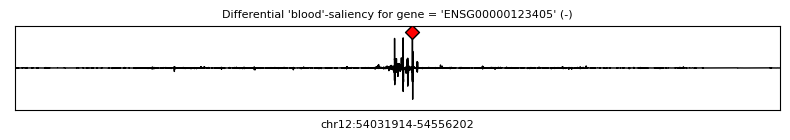

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272420
 - max_pos (abs) = 54304334
 - chr12:54304238-54304430
blood


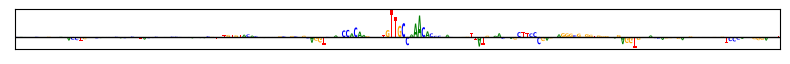

liver


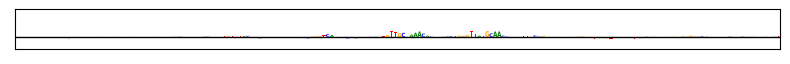

brain


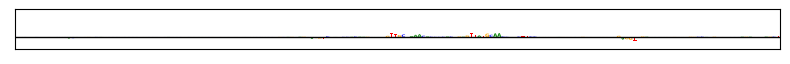

muscle


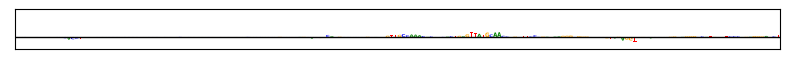

esophagus


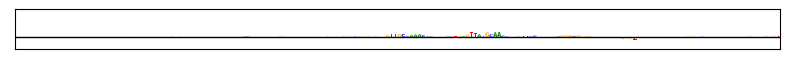

--------------------

-- Example = 35 --
 - ENSG00000124469(-)
 - chr19:42323768-42848056
 -- min_val = -0.771
 -- max_val = 1.043
 - (Gradient score profiles per tissue) - 


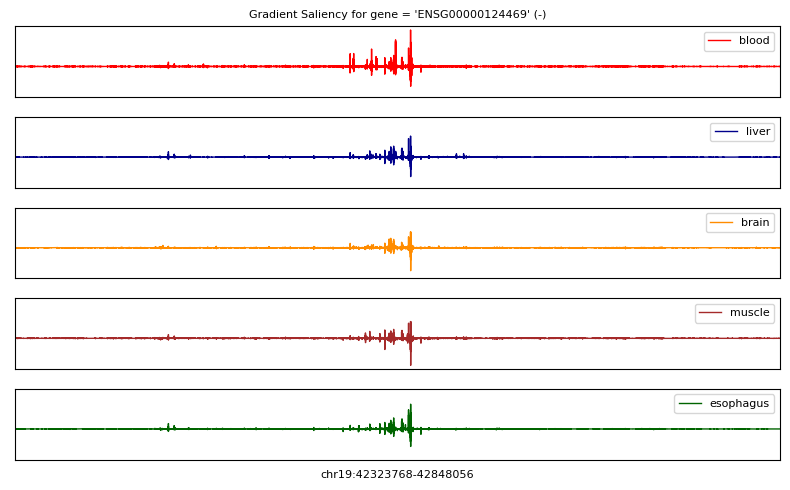

 - (Gradient score comparison against 'blood') - 
liver (r = 0.447)
brain (r = 0.282)
muscle (r = 0.361)
esophagus (r = 0.473)


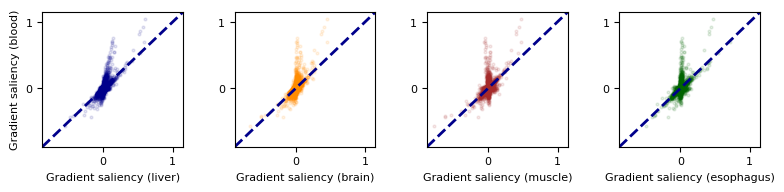

 - (Differential gradient score of blood against 'mean') -


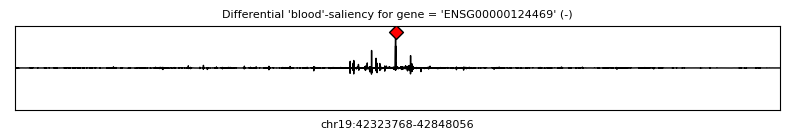

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 260883
 - max_pos (abs) = 42584651
 - chr19:42584555-42584747
blood


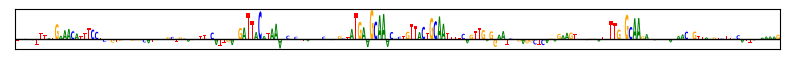

liver


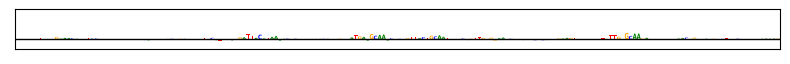

brain


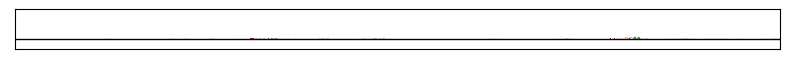

muscle


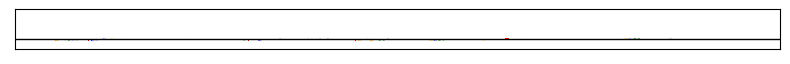

esophagus


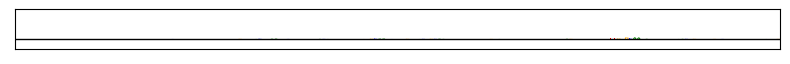

--------------------

-- Example = 36 --
 - ENSG00000189068(-)
 - chr19:53788928-54313216
 -- min_val = -2.086
 -- max_val = 2.707
 - (Gradient score profiles per tissue) - 


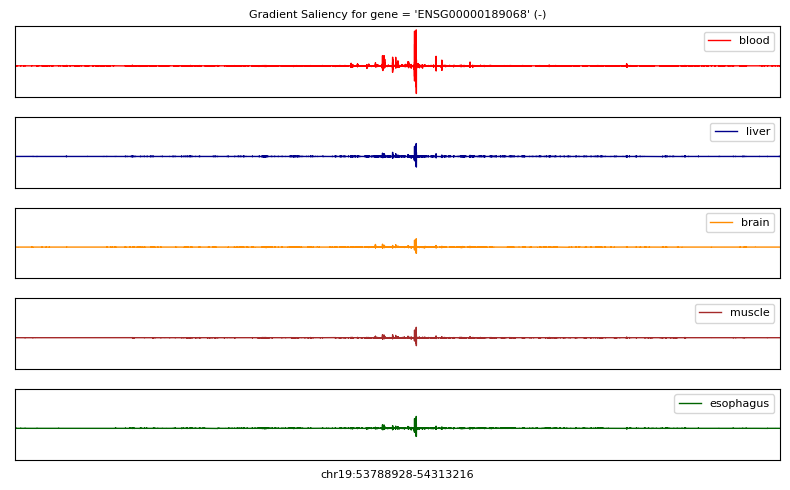

 - (Gradient score comparison against 'blood') - 
liver (r = 0.631)
brain (r = 0.442)
muscle (r = 0.492)
esophagus (r = 0.658)


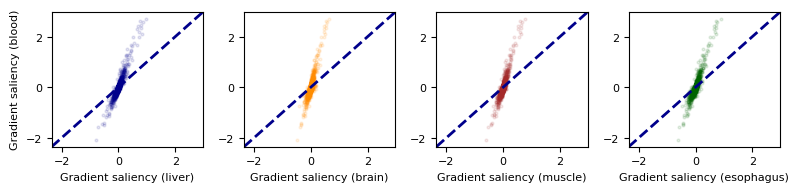

 - (Differential gradient score of blood against 'mean') -


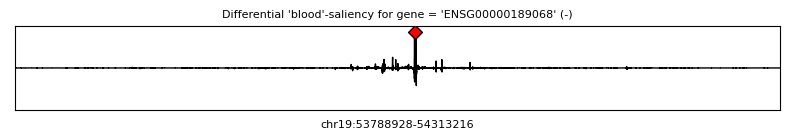

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 273883
 - max_pos (abs) = 54062811
 - chr19:54062715-54062907
blood


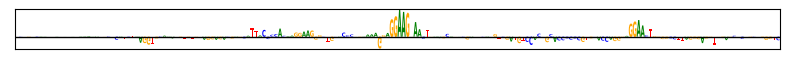

liver


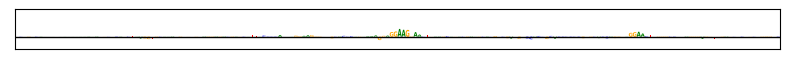

brain


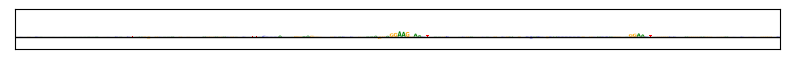

muscle


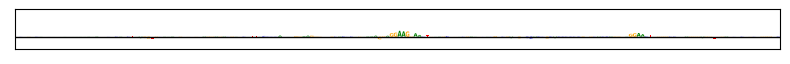

esophagus


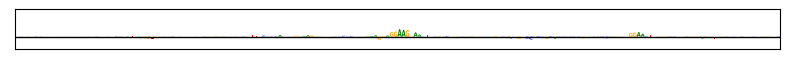

--------------------

-- Example = 37 --
 - ENSG00000257335(+)
 - chr7:141802295-142326583
 -- min_val = -0.871
 -- max_val = 1.355
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


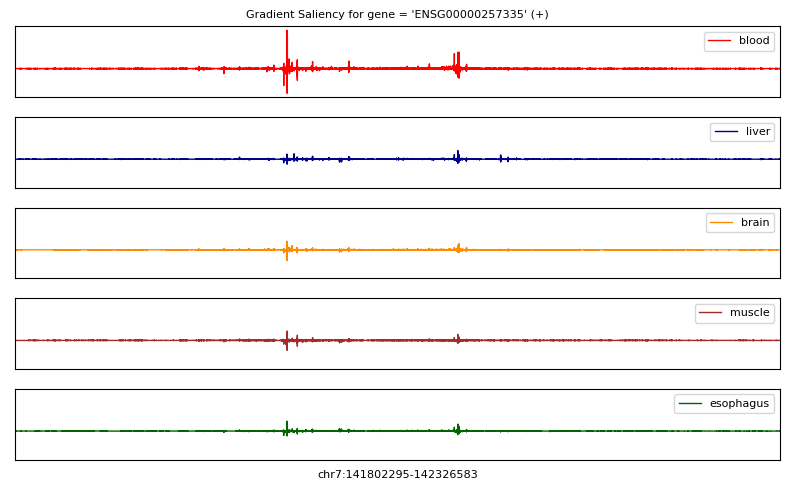

 - (Gradient score comparison against 'blood') - 
liver (r = 0.37)
brain (r = 0.526)
muscle (r = 0.559)
esophagus (r = 0.585)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


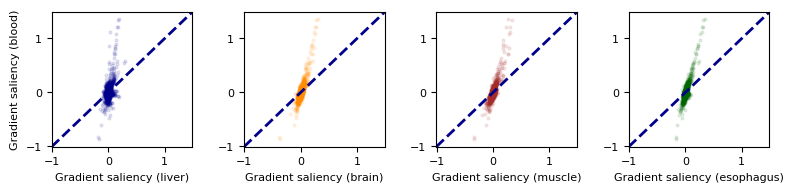

 - (Differential gradient score of blood against 'mean') -


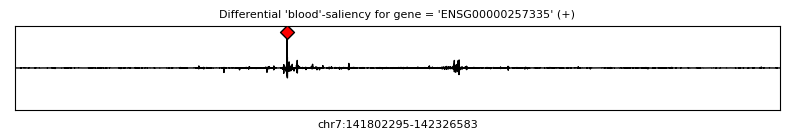

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 186529
 - max_pos (abs) = 141988824
 - chr7:141988728-141988920
blood


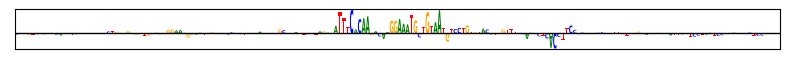

liver


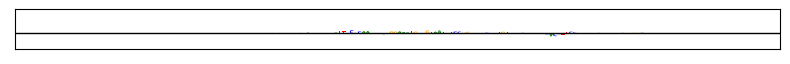

brain


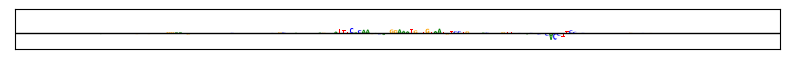

muscle


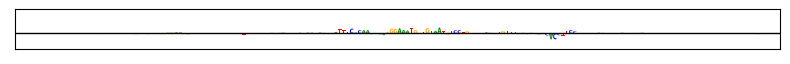

esophagus


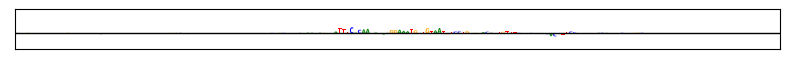

--------------------

-- Example = 38 --
 - ENSG00000164047(+)
 - chr3:47962314-48486602
 -- min_val = -1.195
 -- max_val = 2.357
 - (Gradient score profiles per tissue) - 


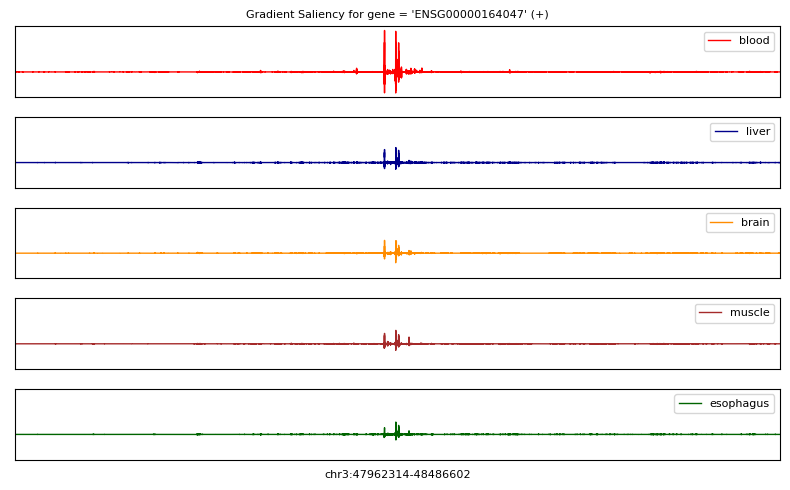

 - (Gradient score comparison against 'blood') - 
liver (r = 0.555)
brain (r = 0.364)
muscle (r = 0.327)
esophagus (r = 0.483)


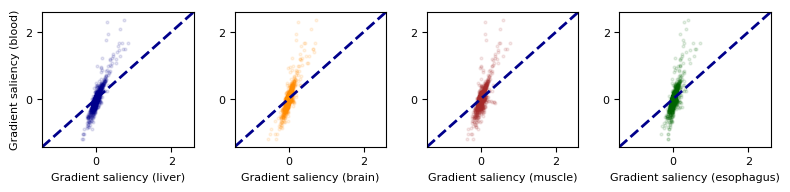

 - (Differential gradient score of blood against 'mean') -


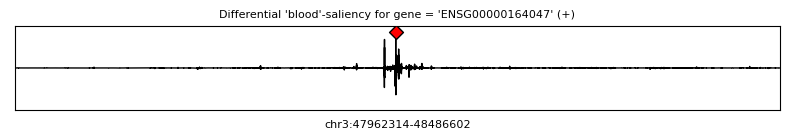

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 260983
 - max_pos (abs) = 48223297
 - chr3:48223201-48223393
blood


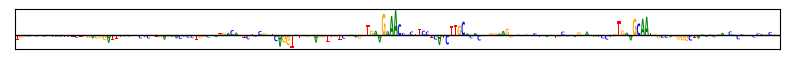

liver


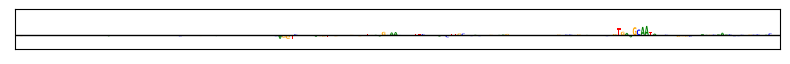

brain


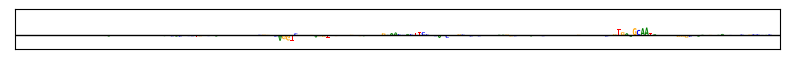

muscle


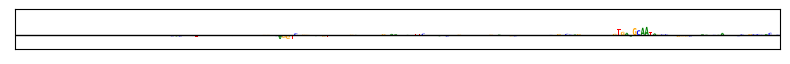

esophagus


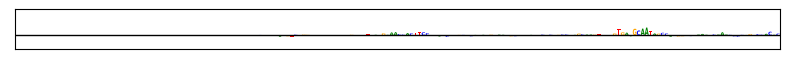

--------------------

-- Example = 39 --
 - ENSG00000085265(-)
 - chr9:134645268-135169556
 -- min_val = -2.066
 -- max_val = 2.525
 - (Gradient score profiles per tissue) - 


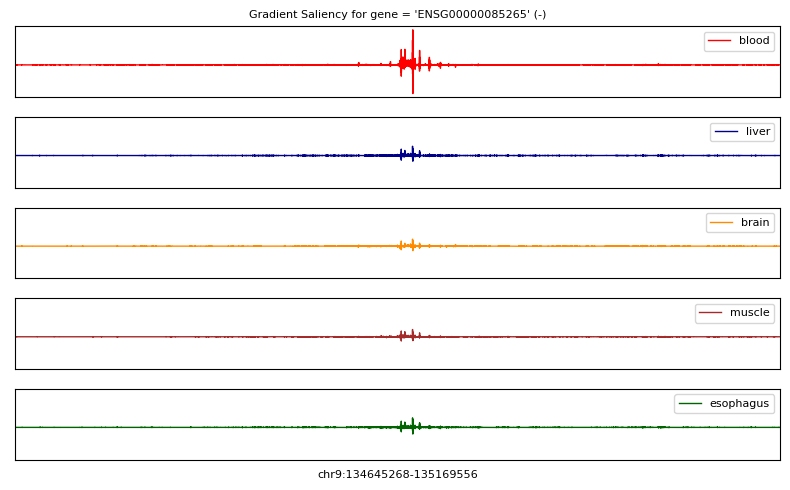

 - (Gradient score comparison against 'blood') - 
liver (r = 0.515)
brain (r = 0.349)
muscle (r = 0.388)
esophagus (r = 0.545)


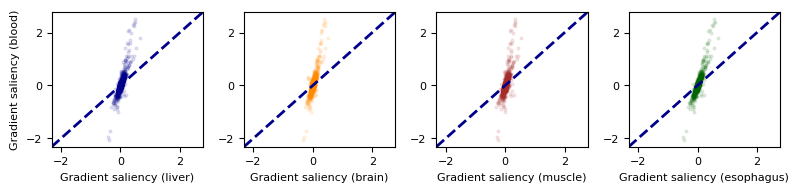

 - (Differential gradient score of blood against 'mean') -


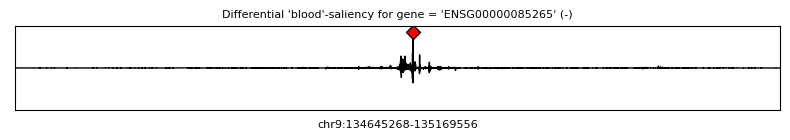

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272681
 - max_pos (abs) = 134917949
 - chr9:134917853-134918045
blood


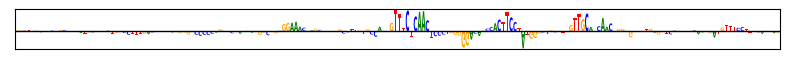

liver


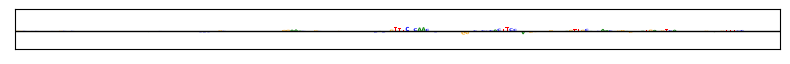

brain


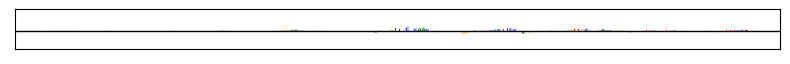

muscle


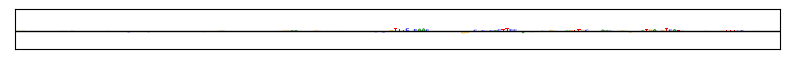

esophagus


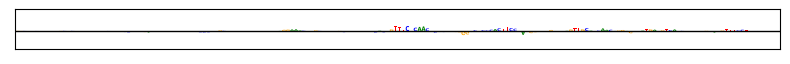

--------------------

-- Example = 40 --
 - ENSG00000133742(-)
 - chr8:85070557-85594845
 -- min_val = -0.8193
 -- max_val = 1.225
 - (Gradient score profiles per tissue) - 


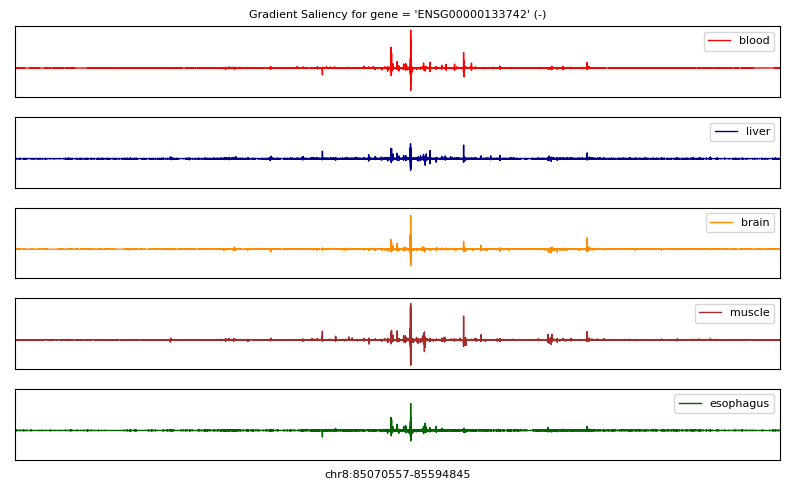

 - (Gradient score comparison against 'blood') - 
liver (r = 0.334)
brain (r = 0.504)
muscle (r = 0.333)
esophagus (r = 0.521)


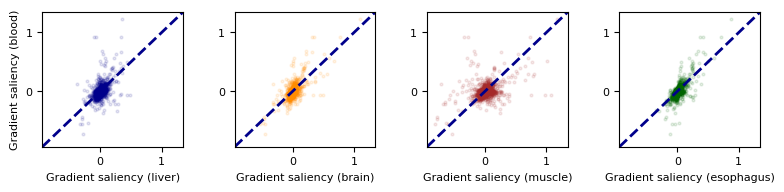

 - (Differential gradient score of blood against 'mean') -


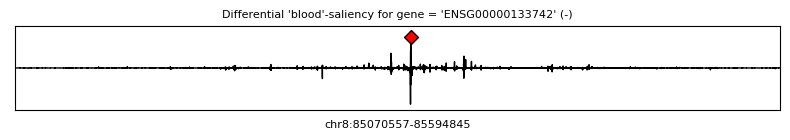

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271239
 - max_pos (abs) = 85341796
 - chr8:85341700-85341892
blood


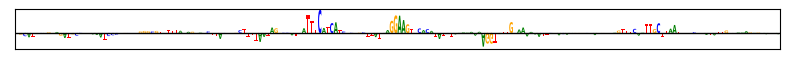

liver


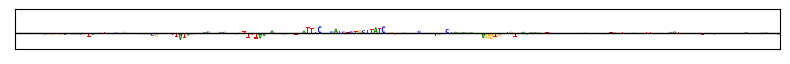

brain


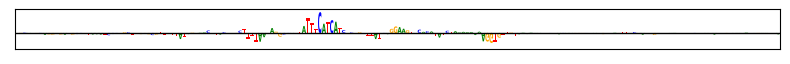

muscle


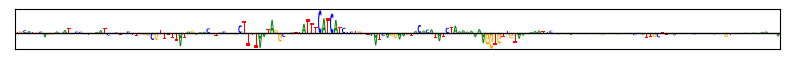

esophagus


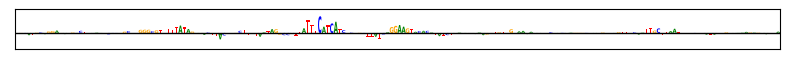

--------------------

-- Example = 41 --
 - ENSG00000166527(+)
 - chr12:8257745-8782033
 -- min_val = -0.4253
 -- max_val = 1.727
 - (Gradient score profiles per tissue) - 


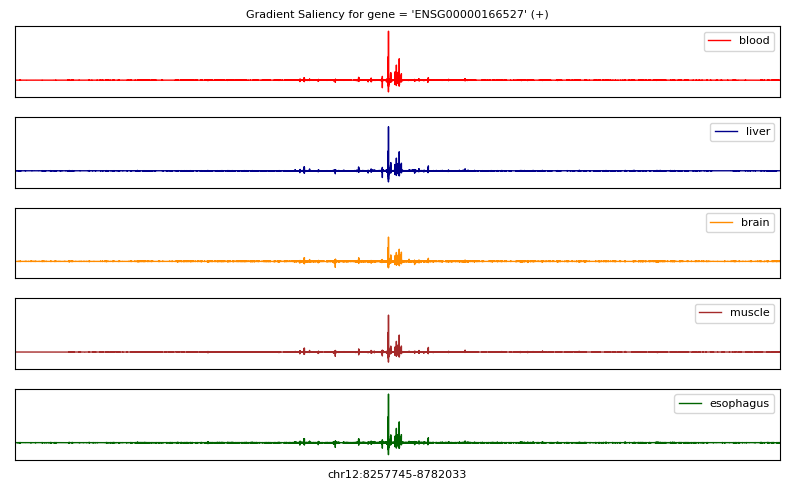

 - (Gradient score comparison against 'blood') - 
liver (r = 0.696)
brain (r = 0.414)
muscle (r = 0.586)
esophagus (r = 0.715)


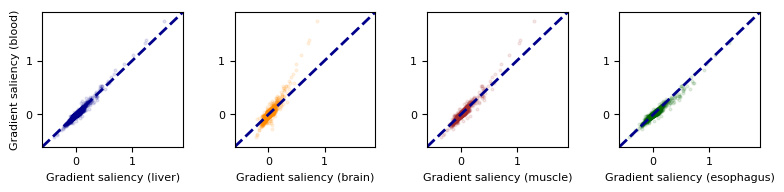

 - (Differential gradient score of blood against 'mean') -


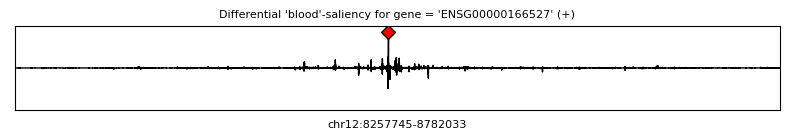

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 256016
 - max_pos (abs) = 8513761
 - chr12:8513665-8513857
blood


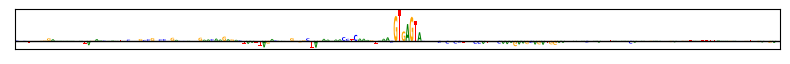

liver


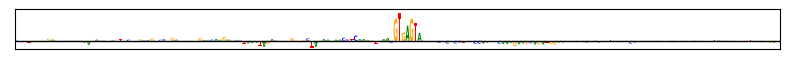

brain


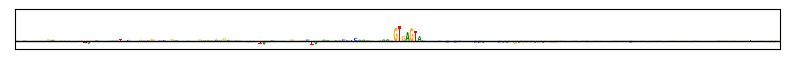

muscle


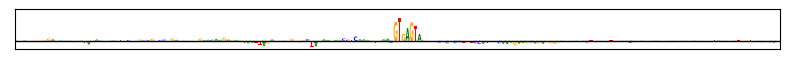

esophagus


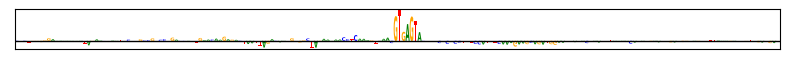

--------------------

-- Example = 42 --
 - ENSG00000163736(-)
 - chr4:73725041-74249329
 -- min_val = -0.7515
 -- max_val = 0.9473
 - (Gradient score profiles per tissue) - 


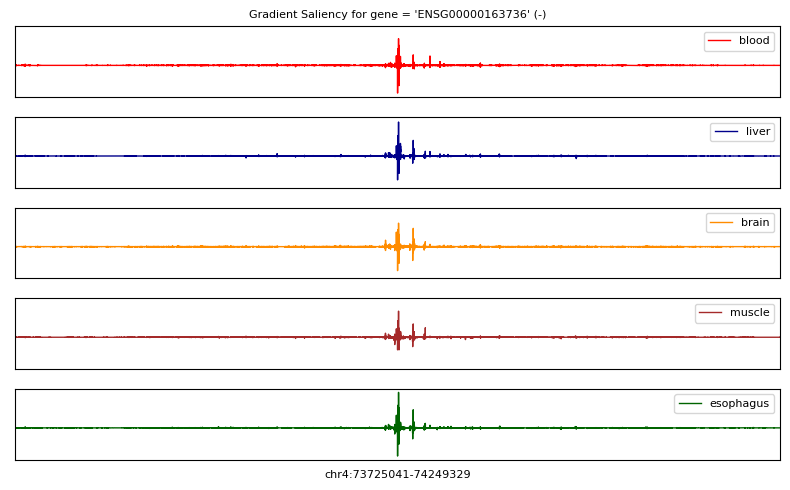

 - (Gradient score comparison against 'blood') - 
liver (r = 0.469)
brain (r = 0.354)
muscle (r = 0.313)
esophagus (r = 0.451)


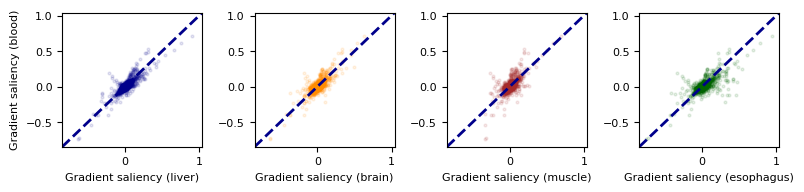

 - (Differential gradient score of blood against 'mean') -


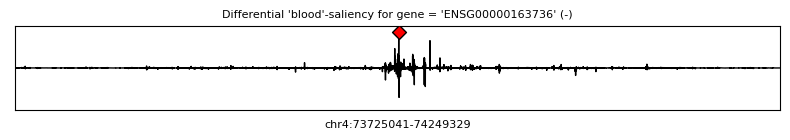

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263035
 - max_pos (abs) = 73988076
 - chr4:73987980-73988172
blood


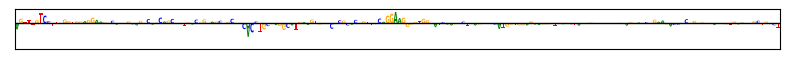

liver


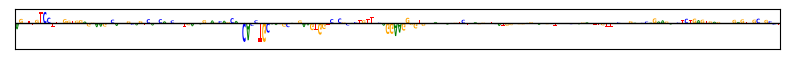

brain


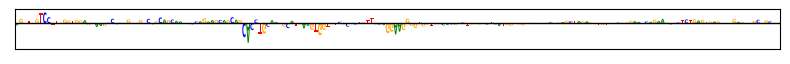

muscle


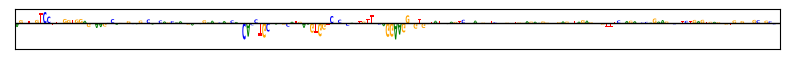

esophagus


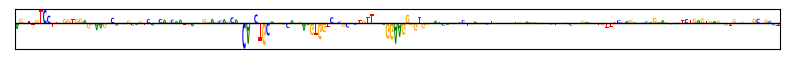

--------------------

-- Example = 43 --
 - ENSG00000180549(-)
 - chr9:136768876-137293164
 -- min_val = -0.6914
 -- max_val = 1.525
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


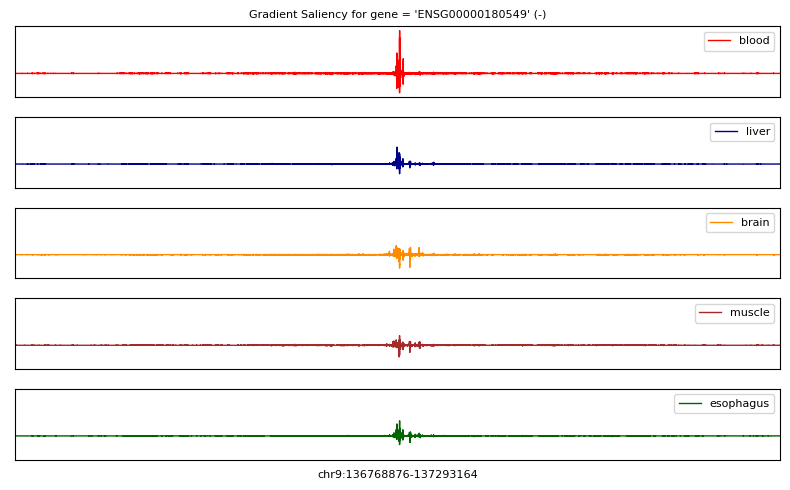

 - (Gradient score comparison against 'blood') - 
liver (r = 0.181)
brain (r = -0.013)
muscle (r = 0.119)
esophagus (r = 0.187)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


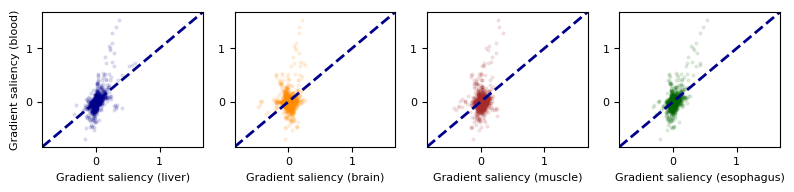

 - (Differential gradient score of blood against 'mean') -


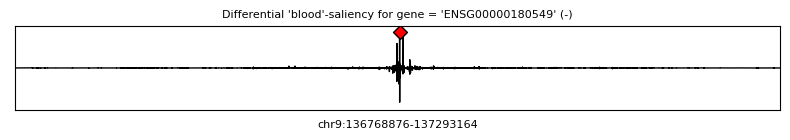

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263646
 - max_pos (abs) = 137032522
 - chr9:137032426-137032618
blood


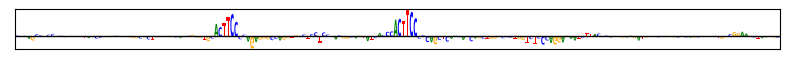

liver


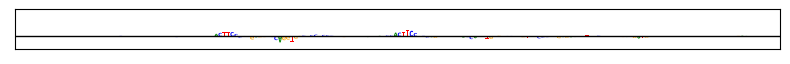

brain


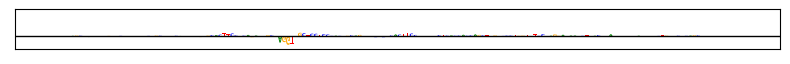

muscle


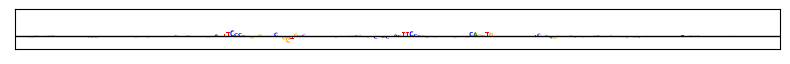

esophagus


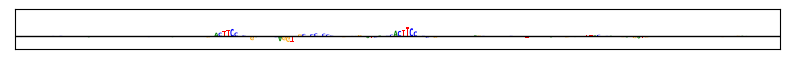

--------------------

-- Example = 44 --
 - ENSG00000100985(+)
 - chr20:45750380-46274668
 -- min_val = -1.052
 -- max_val = 2.242
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


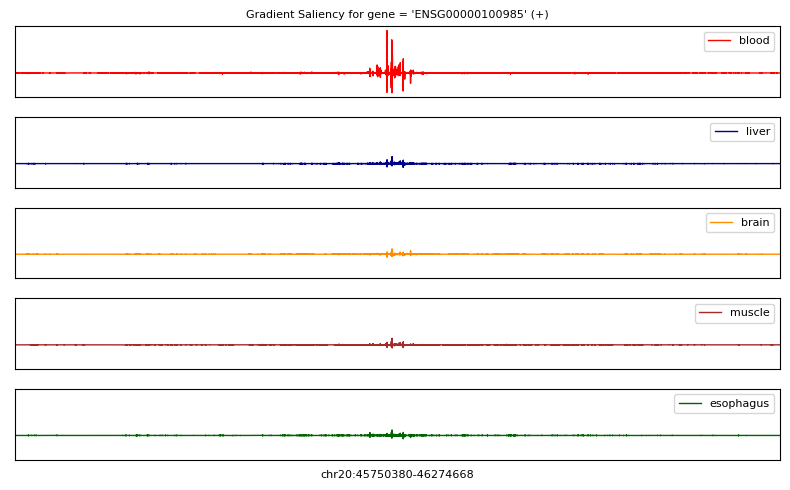

 - (Gradient score comparison against 'blood') - 
liver (r = 0.369)
brain (r = 0.239)
muscle (r = 0.142)
esophagus (r = 0.234)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


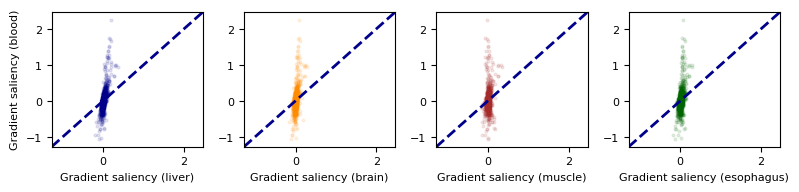

 - (Differential gradient score of blood against 'mean') -


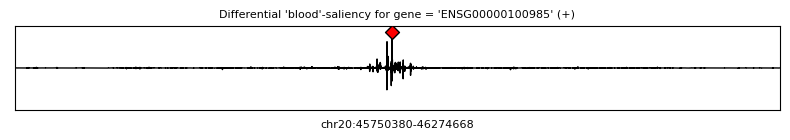

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 258262
 - max_pos (abs) = 46008642
 - chr20:46008546-46008738
blood


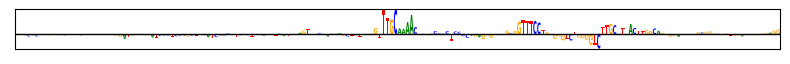

liver


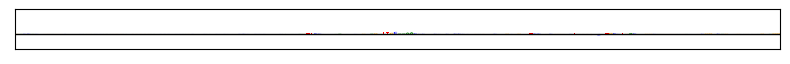

brain


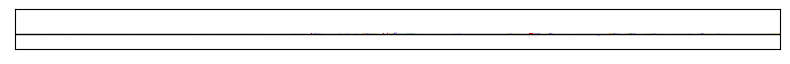

muscle


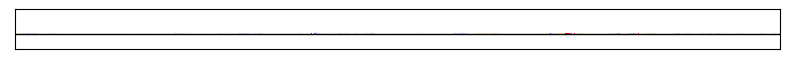

esophagus


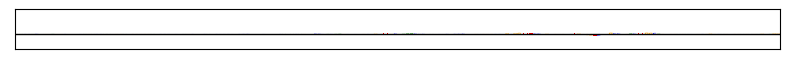

--------------------

-- Example = 45 --
 - ENSG00000076662(-)
 - chr19:10073518-10597806
 -- min_val = -1.727
 -- max_val = 2.86
 - (Gradient score profiles per tissue) - 


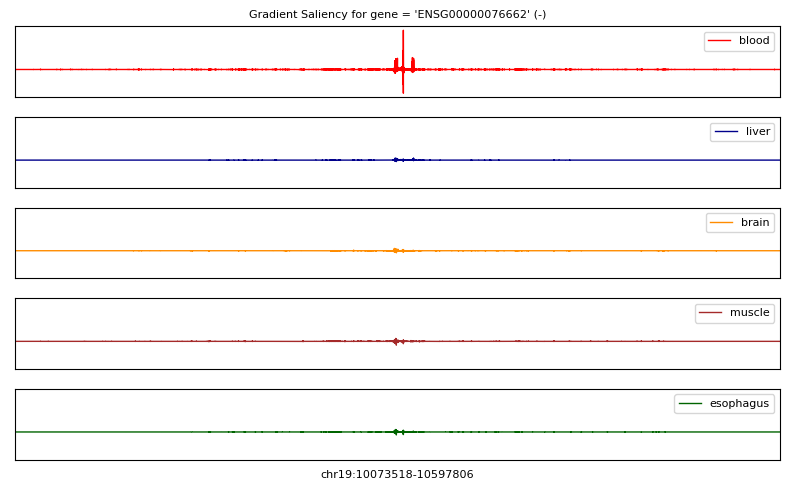

 - (Gradient score comparison against 'blood') - 
liver (r = 0.22)
brain (r = 0.197)
muscle (r = 0.056)
esophagus (r = 0.296)


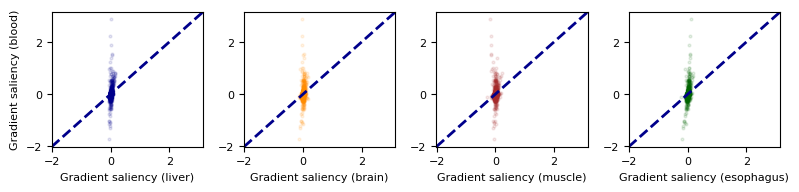

 - (Differential gradient score of blood against 'mean') -


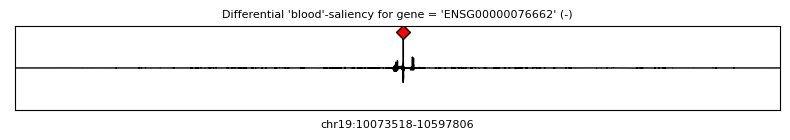

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 266192
 - max_pos (abs) = 10339710
 - chr19:10339614-10339806
blood


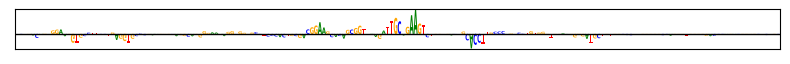

liver


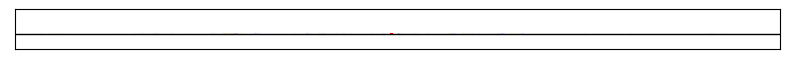

brain


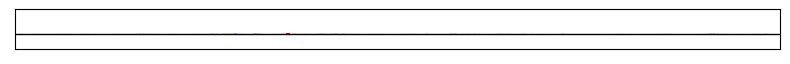

muscle


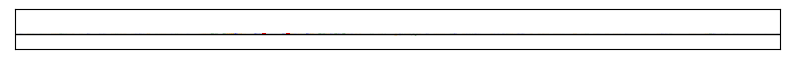

esophagus


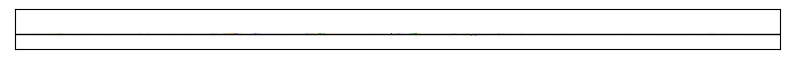

--------------------

-- Example = 46 --
 - ENSG00000142405(-)
 - chr19:53545852-54070140
 -- min_val = -1.094
 -- max_val = 0.892
 - (Gradient score profiles per tissue) - 


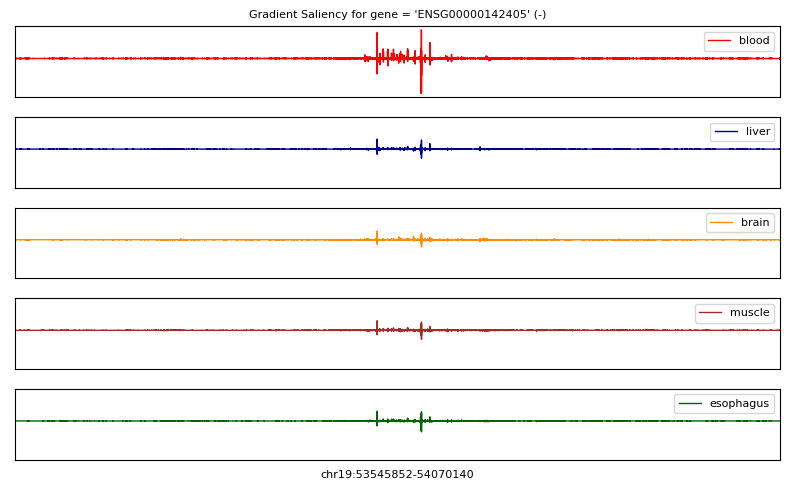

 - (Gradient score comparison against 'blood') - 
liver (r = 0.416)
brain (r = 0.304)
muscle (r = 0.351)
esophagus (r = 0.569)


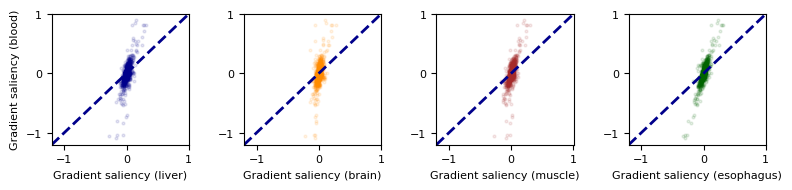

 - (Differential gradient score of blood against 'mean') -


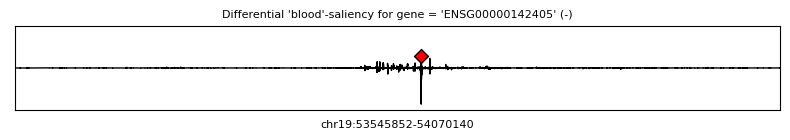

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 278566
 - max_pos (abs) = 53824418
 - chr19:53824322-53824514
blood


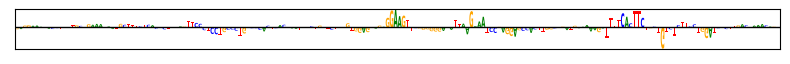

liver


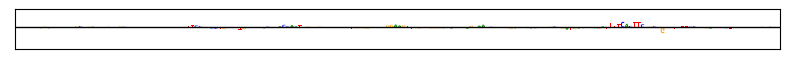

brain


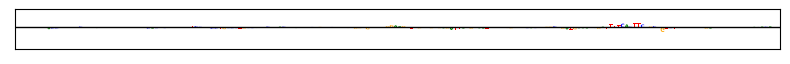

muscle


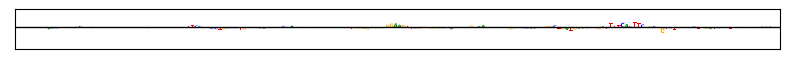

esophagus


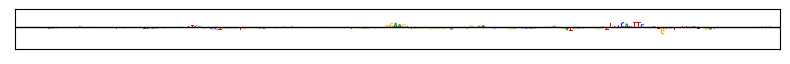

--------------------

-- Example = 47 --
 - ENSG00000169704(+)
 - chr3:128799745-129324033
 -- min_val = -1.781
 -- max_val = 2.002
 - (Gradient score profiles per tissue) - 


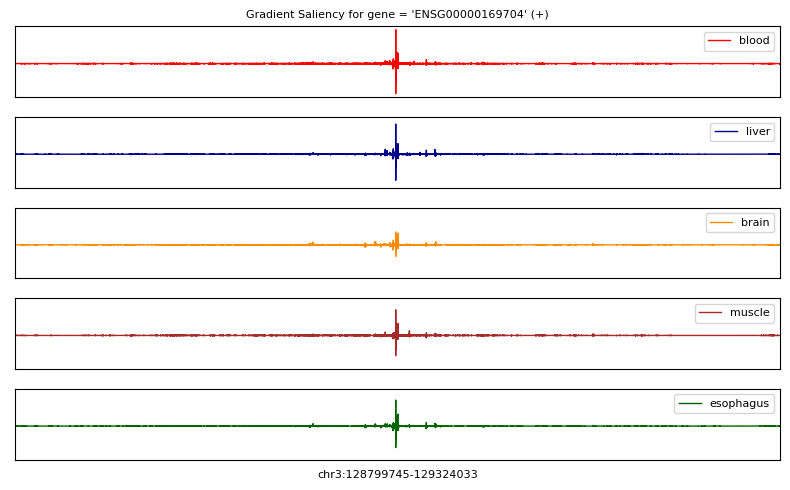

 - (Gradient score comparison against 'blood') - 
liver (r = 0.541)
brain (r = 0.443)
muscle (r = 0.37)
esophagus (r = 0.54)


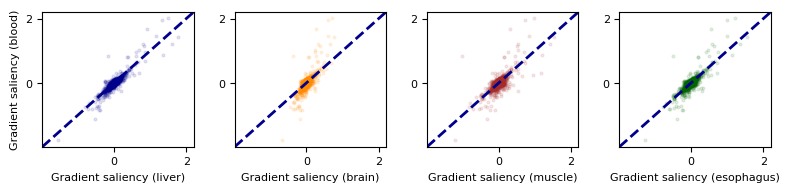

 - (Differential gradient score of blood against 'mean') -


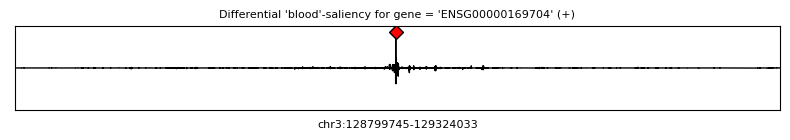

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 260989
 - max_pos (abs) = 129060734
 - chr3:129060638-129060830
blood


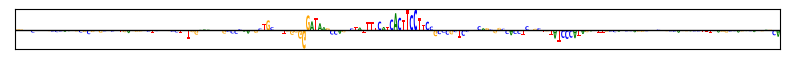

liver


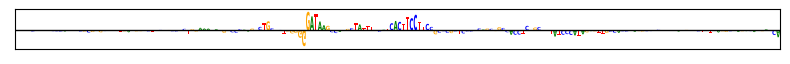

brain


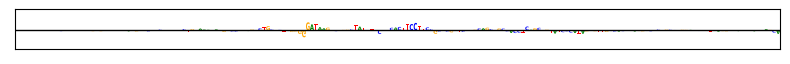

muscle


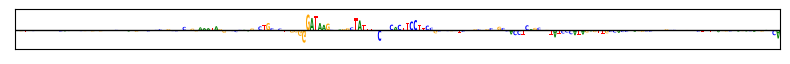

esophagus


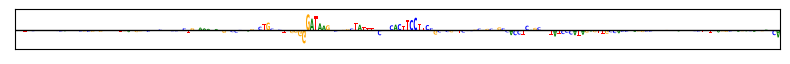

--------------------

-- Example = 48 --
 - ENSG00000239998(+)
 - chr19:54322467-54846755
 -- min_val = -0.7
 -- max_val = 1.875
 - (Gradient score profiles per tissue) - 


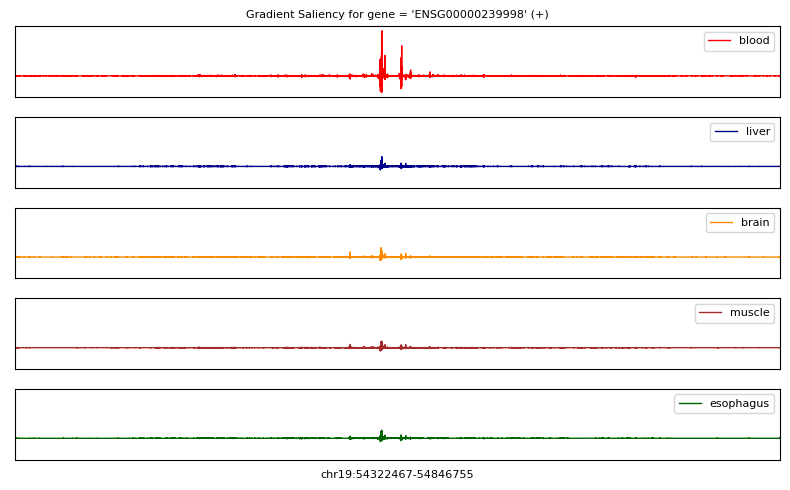

 - (Gradient score comparison against 'blood') - 
liver (r = 0.468)
brain (r = 0.361)
muscle (r = 0.344)
esophagus (r = 0.521)


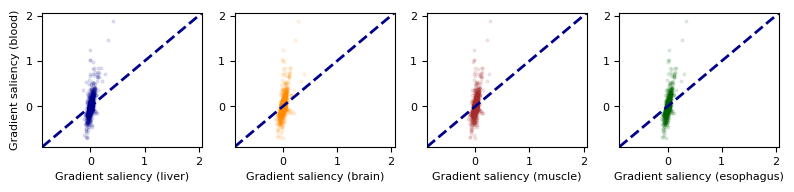

 - (Differential gradient score of blood against 'mean') -


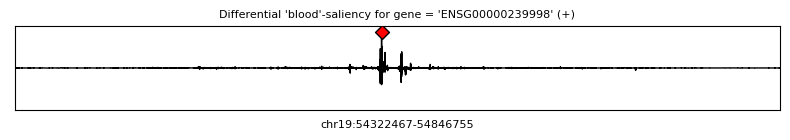

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251282
 - max_pos (abs) = 54573749
 - chr19:54573653-54573845
blood


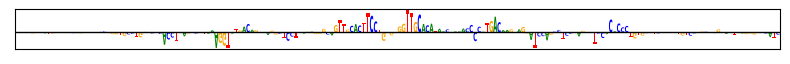

liver


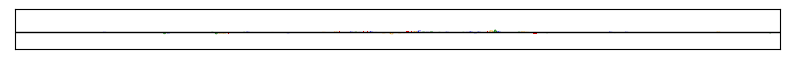

brain


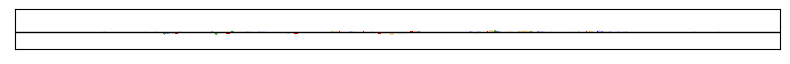

muscle


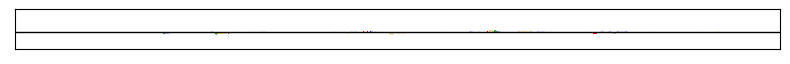

esophagus


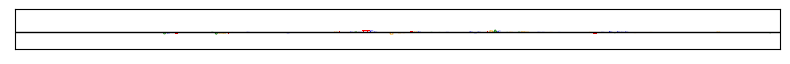

--------------------

-- Example = 49 --
 - ENSG00000174837(+)
 - chr19:6655798-7180086
 -- min_val = -1.859
 -- max_val = 2.254
 - (Gradient score profiles per tissue) - 


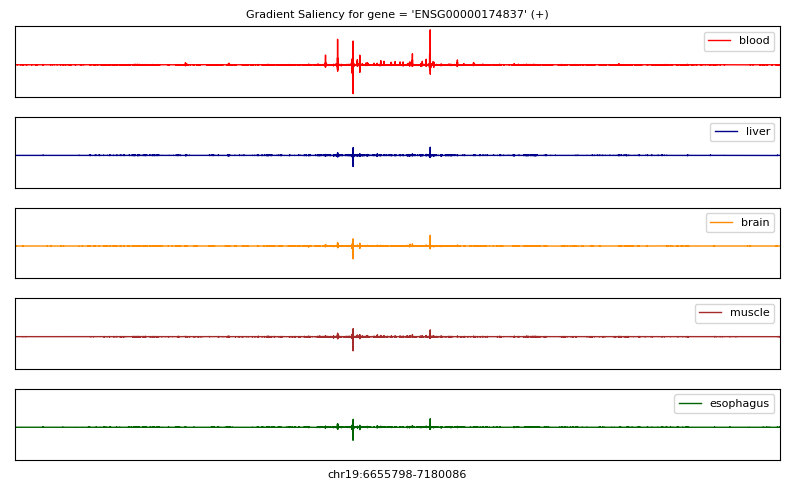

 - (Gradient score comparison against 'blood') - 
liver (r = 0.404)
brain (r = 0.384)
muscle (r = 0.386)
esophagus (r = 0.503)


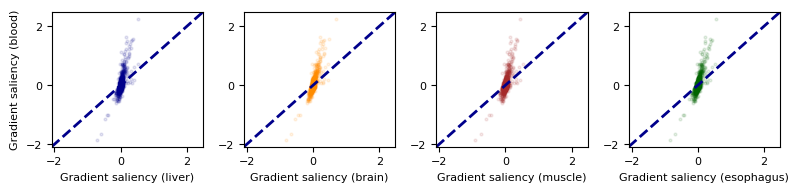

 - (Differential gradient score of blood against 'mean') -


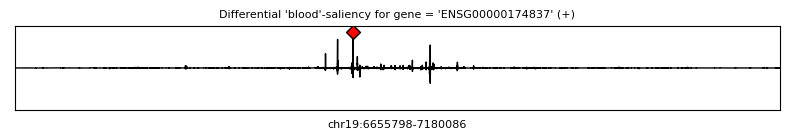

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 231702
 - max_pos (abs) = 6887500
 - chr19:6887404-6887596
blood


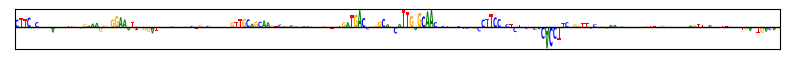

liver


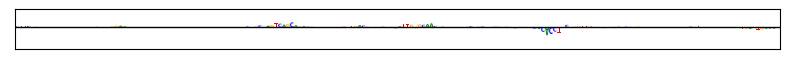

brain


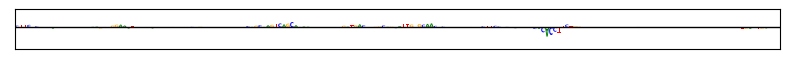

muscle


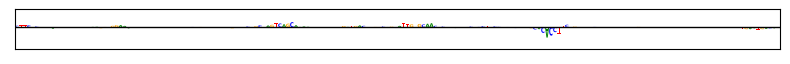

esophagus


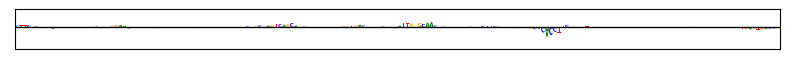

--------------------



In [24]:
#Enumerate and visualize attributions (relative fold changes); blood

save_figs = True
save_prefix = 'attribution_figs/borzoi_v2_diff_expr_grads_5_tissues_4_folds_' + tissue

save_index = [3, 17, 37, 43, 44] #, 19

#Select tissue to find maximally differential score locus for
main_tissue_ix = 0

#Visualization parameters
logo_width = 192

top_n = 50

use_gaussian = True
min_padding = 65536
gaussian_sigma = 8

tissue_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

#Loop over examples
for example_ix in range(top_n) :
    
    print("-- Example = " + str(example_ix)+ " --")
    
    save_figs_curr = False
    if save_figs and example_ix in set(save_index) :
        save_figs_curr = True
    
    print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

    #Grad analysis
    
    #Calculate min and max scores globally (for scales)
    min_val = np.min(scores[:, example_ix, ...])
    max_val = np.max(scores[:, example_ix, ...])
    
    print(" -- min_val = " + str(round(min_val, 4)))
    print(" -- max_val = " + str(round(max_val, 4)))
    
    max_abs_val = max(np.abs(min_val), np.abs(max_val))

    min_val -= 0.1 * max_abs_val
    max_val += 0.1 * max_abs_val

    print(" - (Gradient score profiles per tissue) - ")
    
    #Gradient profiles across input sequence
    f, ax = plt.subplots(len(gtex_tissues), 1, figsize=(8, len(gtex_tissues) * 1))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :

        #Get tissue scores
        score = scores[tissue_ix, example_ix, ...]

        l1 = ax[tissue_ix].plot(np.arange(seqs.shape[1]), np.sum(score, axis=-1), linewidth=1, linestyle='-', color=tissue_colors[tissue_ix], label=gtex_tissues[tissue_ix])
        
        plt.sca(ax[tissue_ix])
        
        plt.xlim(0, seqs.shape[1])
        plt.ylim(min_val, max_val)
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])
    
    plt.sca(ax[0])
    plt.title("Gradient Saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.sca(ax[len(gtex_tissues)-1])
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".eps")
    
    plt.show()
    
    print(" - (Gradient score comparison against '" + gtex_tissues[main_tissue_ix] + "') - ")

    #Scatter plots of pairs of tissue-specific gradient scores
    f, ax = plt.subplots(1, len(gtex_tissues)-1, figsize=((len(gtex_tissues)-1) * 2, 2))
    
    #Gradient saliency for main tissue
    score_2 = scores[main_tissue_ix, example_ix, ...]

    #Loop over (other) tissues
    ax_ix = 0
    for tissue_ix in range(len(gtex_tissues)) :

        if tissue_ix != main_tissue_ix :
            
            #Gradient saliency for other tissue
            score_1 = scores[tissue_ix, example_ix, ...]
            
            #Compute spearman correlation between scores
            r_val, _ = spearmanr(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1))
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_val, 3)) + ")")

            #Scatter plot of scores
            ax[ax_ix].scatter(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.1)

            ax[ax_ix].plot([min_val, max_val], [min_val, max_val], linewidth=2, linestyle='--', color='darkblue')

            plt.sca(ax[ax_ix])
            
            plt.xlim(min_val, max_val)
            plt.ylim(min_val, max_val)
            
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            
            ax_ix += 1

    plt.sca(ax[0])
    plt.ylabel("Gradient saliency (" + gtex_tissues[main_tissue_ix] + ")", fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Differential gradient score of " + gtex_tissues[main_tissue_ix] + " against 'mean') -")

    #Get main tissue scores and background scores
    score_2 = scores[main_tissue_ix, example_ix, ...]
    score_1 = np.mean(scores[np.arange(len(gtex_tissues)) != main_tissue_ix, example_ix, ...], axis=0)

    #Compute differential scores
    diff_score = np.sum(score_2 - score_1, axis=-1)
    
    #Apply gaussian filter
    if use_gaussian :
        diff_score = gaussian_filter1d(diff_score.astype('float32'), sigma=gaussian_sigma, truncate=2).astype('float16')
    
    #Calculate min/max positions and (differential) values
    max_pos = np.argmax(diff_score[min_padding:-min_padding]) + min_padding
    min_pos = np.argmin(diff_score[min_padding:-min_padding]) + min_padding

    max_val = np.max(diff_score[min_padding:-min_padding])
    min_val = np.min(diff_score[min_padding:-min_padding])
    
    max_abs_val = max(np.abs(max_val), np.abs(min_val))

    #Plot differential scores
    f = plt.figure(figsize=(8, 1.5))

    plt.plot(np.arange(seqs.shape[1]), diff_score, color='black', linewidth=1, linestyle='-')
    
    plt.scatter([max_pos], [max_val], color='red', marker='D', s=50, linewidth=1, edgecolor='black', zorder=1000)

    plt.xlim(0, seqs.shape[1])
    plt.ylim(-max_abs_val*1.15, max_abs_val*1.15)
    
    plt.xticks([], [])
    plt.yticks([], [])

    plt.title("Differential '" + gtex_tissues[main_tissue_ix] + "'-saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Attribution at position of Max positive differential saliency) -")

    print(" - max_pos (rel) = " + str(max_pos))
    print(" - max_pos (abs) = " + str(starts[example_ix] + max_pos))
    
    #Visualize contribution scores
    plot_start = max_pos - logo_width // 2
    plot_end = max_pos + logo_width // 2
    
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix] + max_pos - logo_width // 2) + "-" + str(starts[example_ix] + max_pos + logo_width // 2))

    #Logo min/max value across tissues
    min_logo_val = np.min(scores[:, example_ix, plot_start:plot_end, :])
    max_logo_val = np.max(scores[:, example_ix, plot_start:plot_end, :])

    max_abs_logo_val = max(np.abs(min_logo_val), np.abs(max_logo_val))

    min_logo_val -= 0.02 * max_abs_logo_val
    max_logo_val += 0.02 * max_abs_logo_val

    print(" - y_min = " + str(round(min_logo_val, 8)))
    print(" - y_max = " + str(round(max_logo_val, 8)))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :
        print(gtex_tissues[tissue_ix])

        #Get tissue-specific scores
        score = scores[tissue_ix, example_ix, plot_start:plot_end, :]

        #Plot scores as sequence logo
        plot_seq_scores(
            score,
            y_min=min_logo_val,
            y_max=max_logo_val,
            figsize=(8, 0.75),
            plot_y_ticks=False,
            save_figs=save_figs_curr,
            fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix),
        )
    
    print("--------------------")
    print("")
